In [1]:
# consts
# number of iterations:
times = 10

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

# Tester results.


In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
data = pd.read_csv("test_result.txt", sep=' ', header=None, names=["lib", 'test', 'test_name'] + [i for i in range(times)])

In [5]:
values = [i for i in range(times)]
data["mean"] = data[values].mean(axis=1)
data["std"]  = data[values].std(axis=1)
data["testid"] = data["test"] + "_" + data["test_name"]
tests = set(data['testid'].tolist())
libs = set(data['lib'].tolist())

## Passed and Failed tests
* GREEN - passed
* RED - failed
* YELLOW - timeout 

In [6]:
passedf = pd.DataFrame(index=libs, columns=tests).fillna(4.75)

dataslice = data[['lib', 'testid', 'mean']]
for index, row in dataslice.iterrows():
    if row["mean"] == -1:
        passedf.set_value(row['lib'], row['testid'], 3.9)
    else:
        passedf.set_value(row['lib'], row['testid'], 2.2)

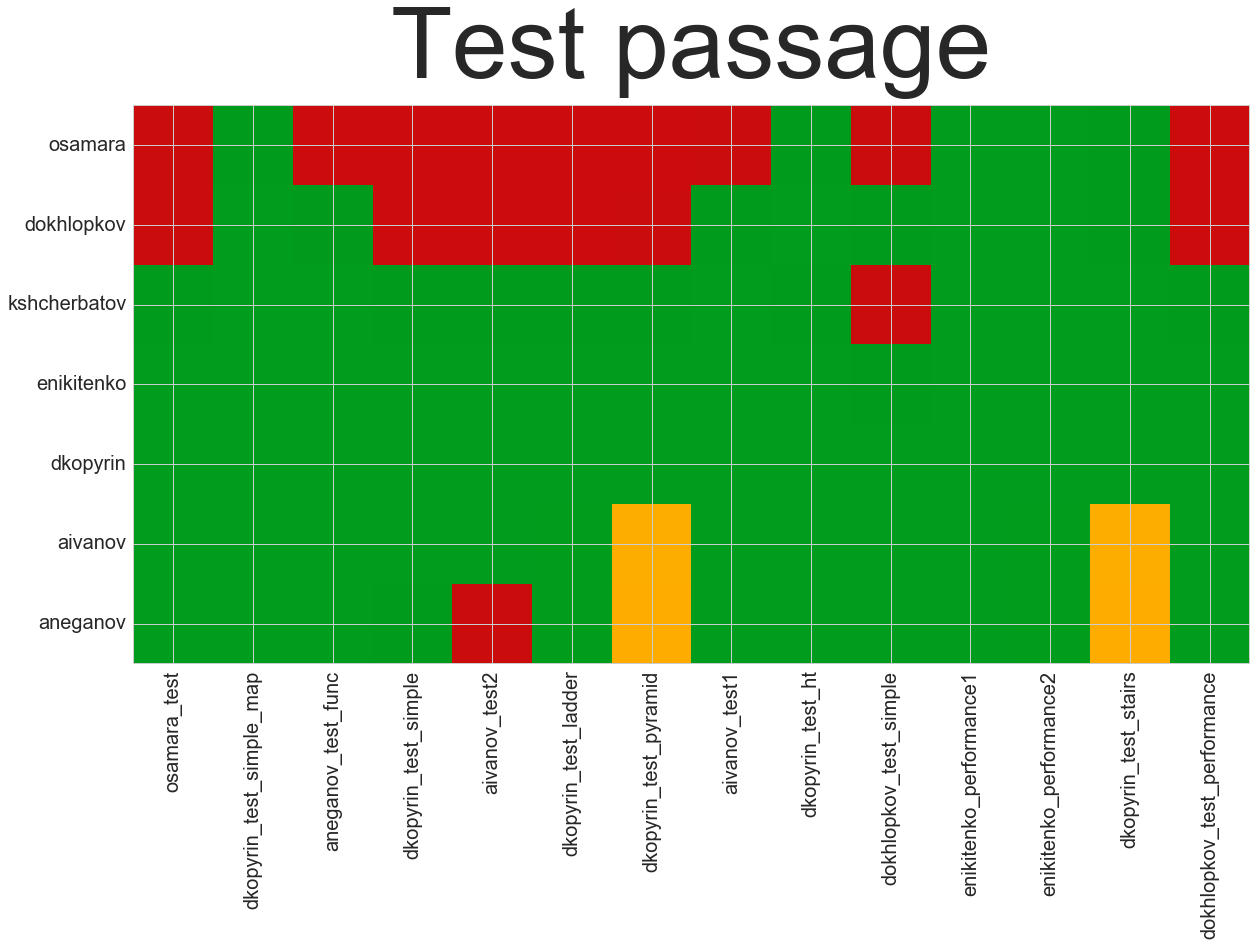

In [7]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
row_labels = libs
col_labels = tests
plt.figure(figsize=(20,10))
plt.title("Test passage", fontsize=100,  y=1.04)
plt.imshow(passedf, interpolation='none', vmin=0, vmax=5, cmap="spectral")
plt.xticks(range(len(tests)), col_labels, rotation=90)
plt.yticks(range(len(libs)), row_labels)
plt.show()

## Results by each test.
There are only libs that passed the test.

In [8]:
# data without timeout values.
passed_data = data[data["mean"] != -1]

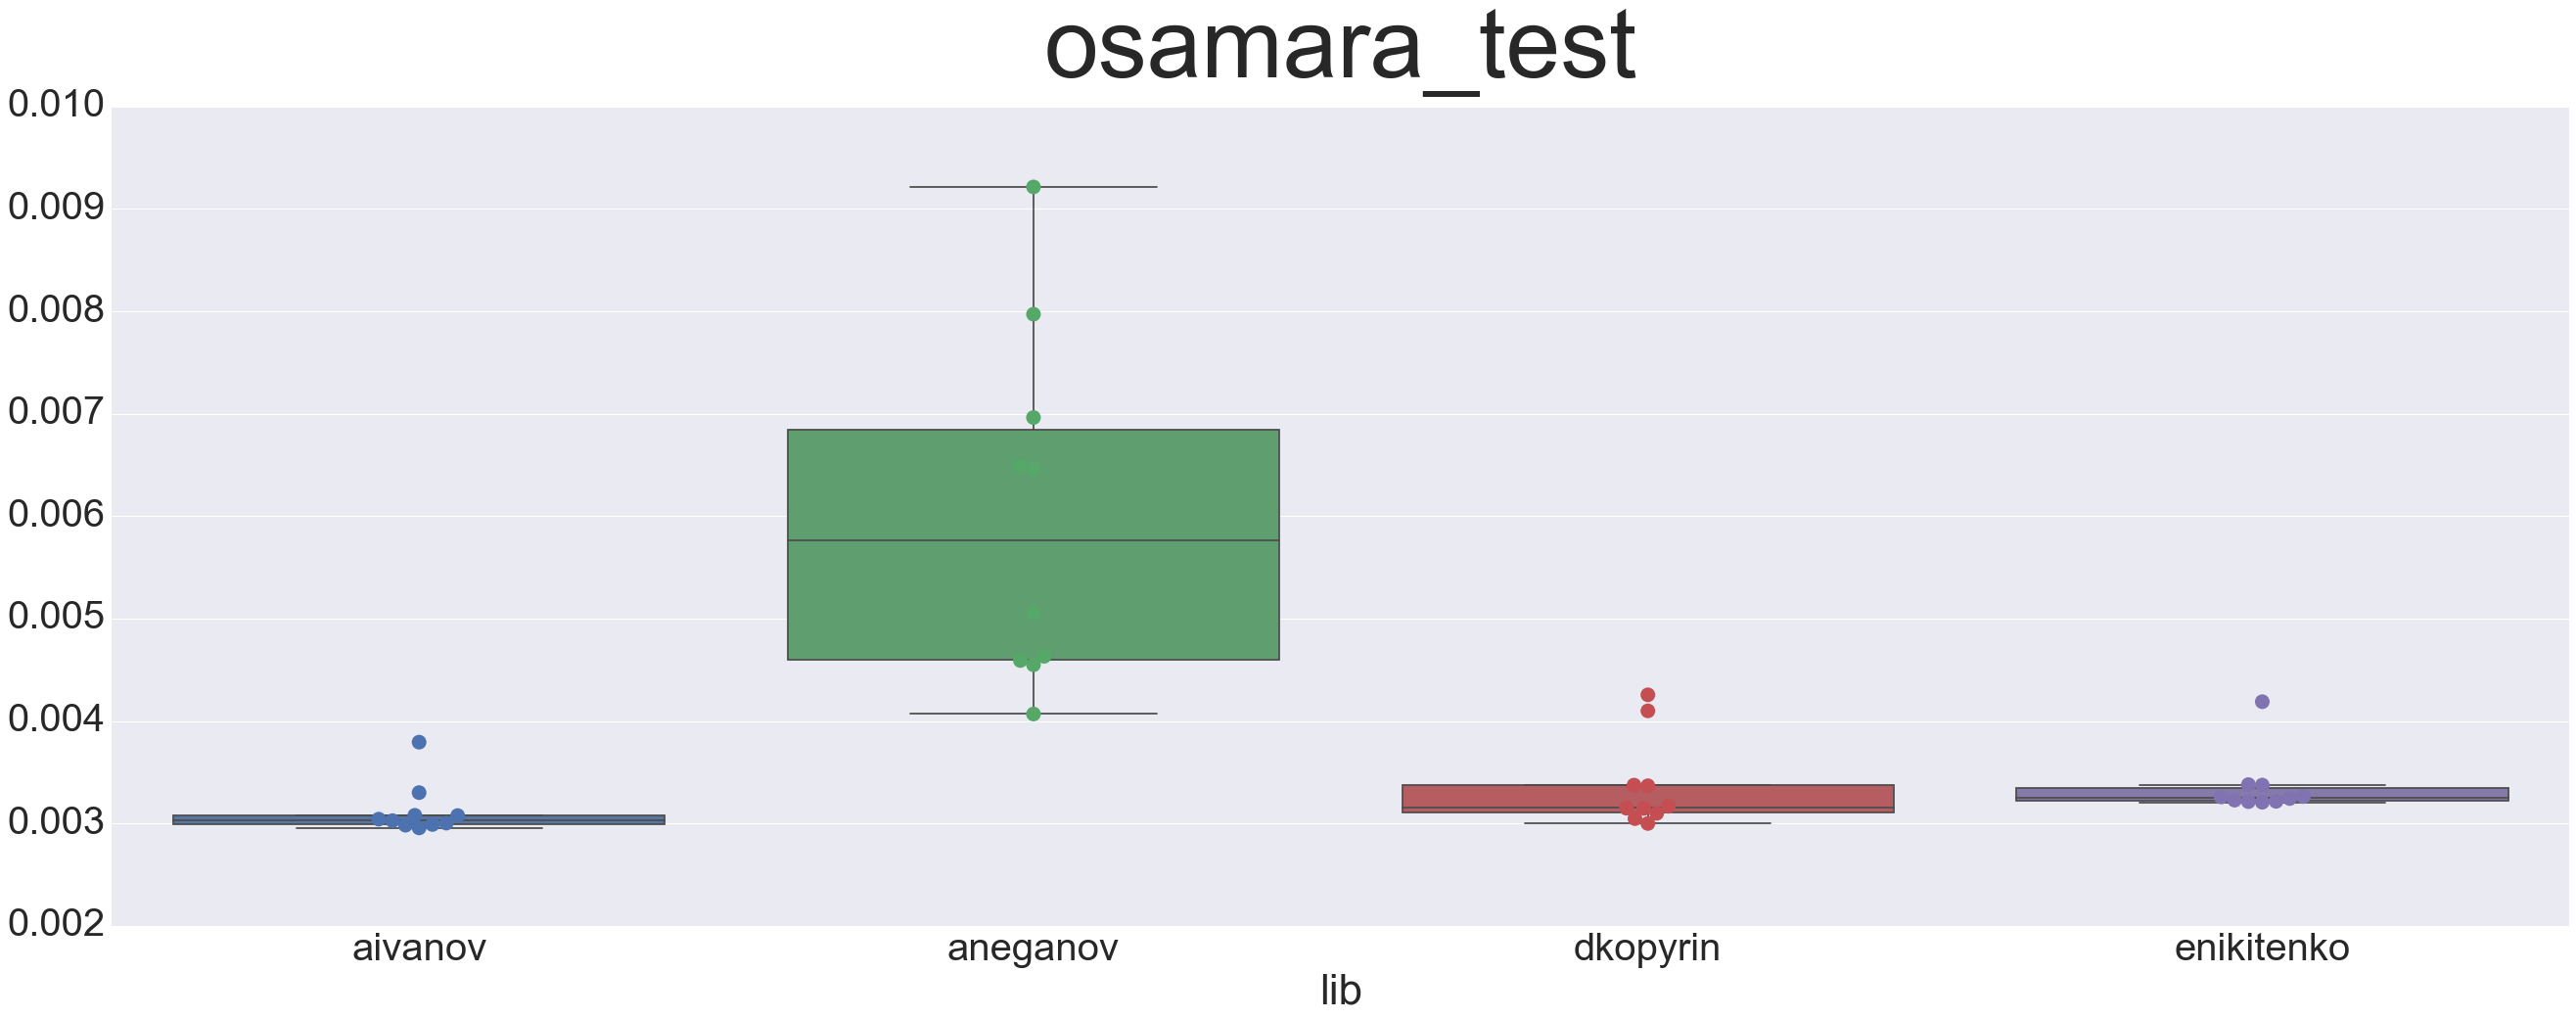

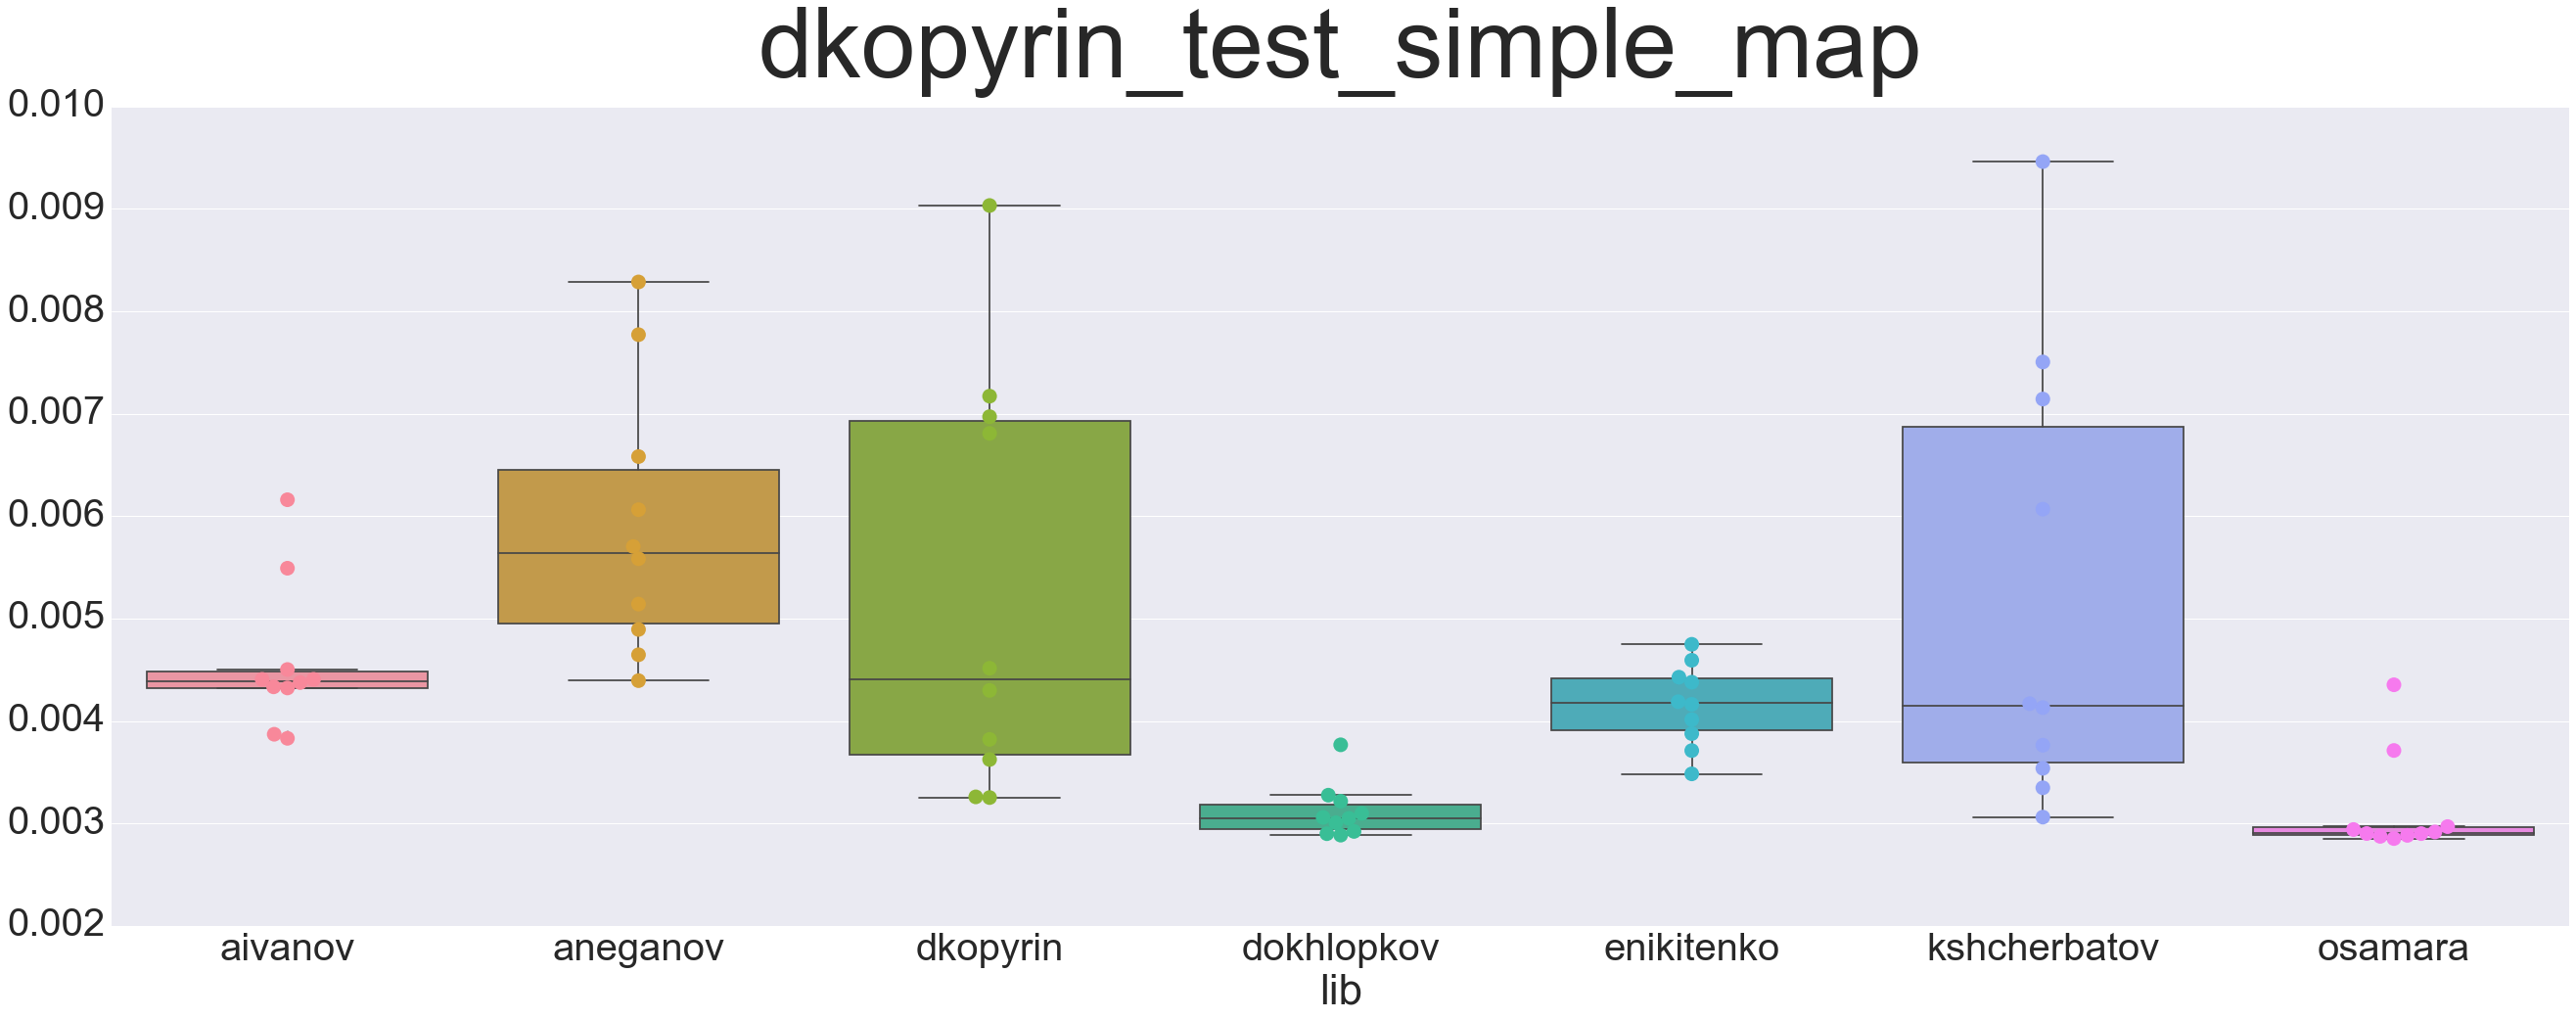

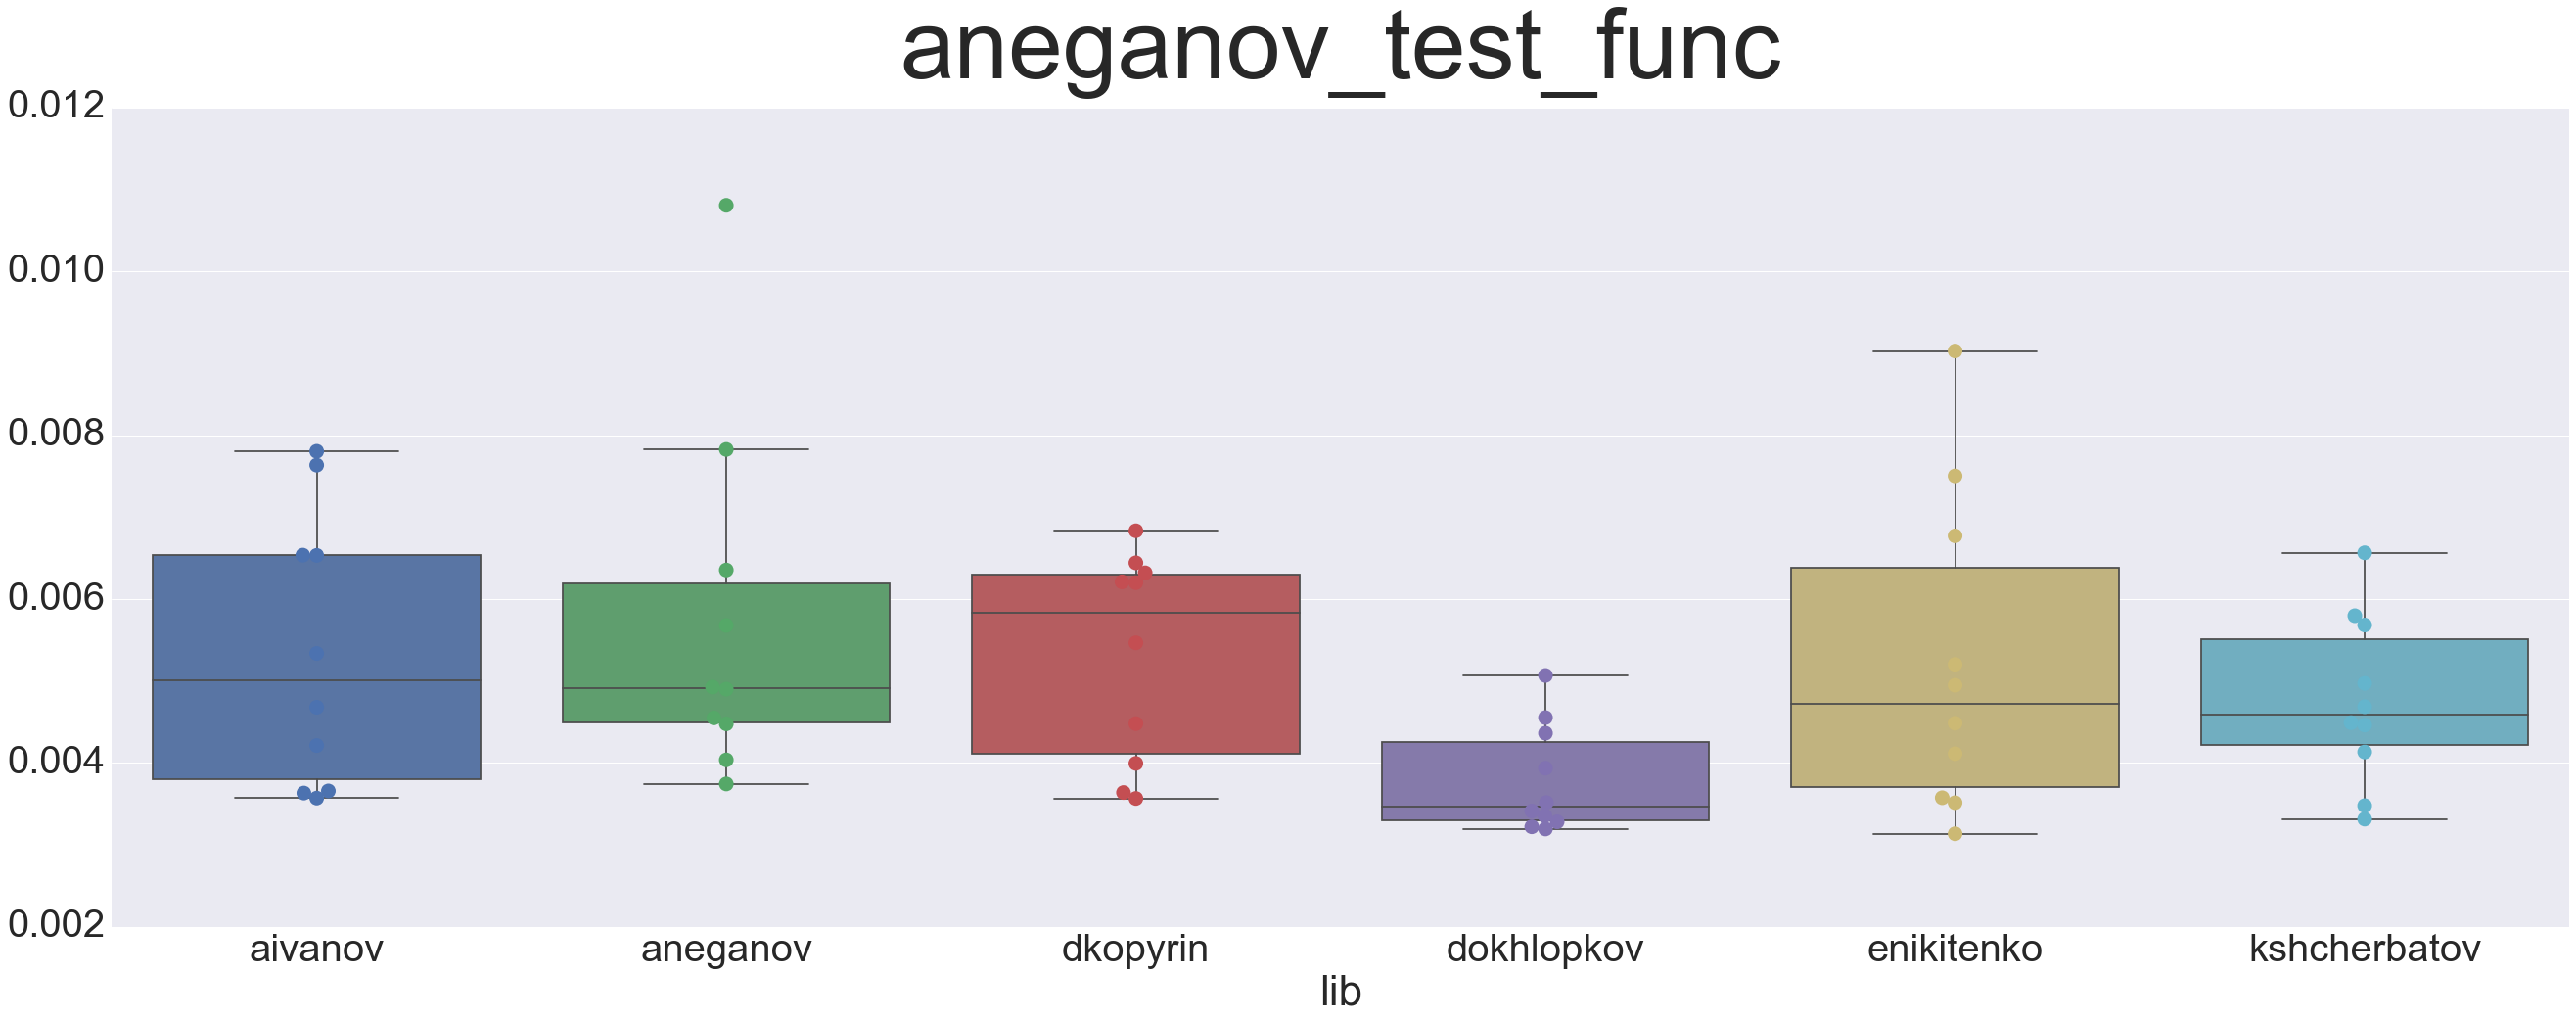

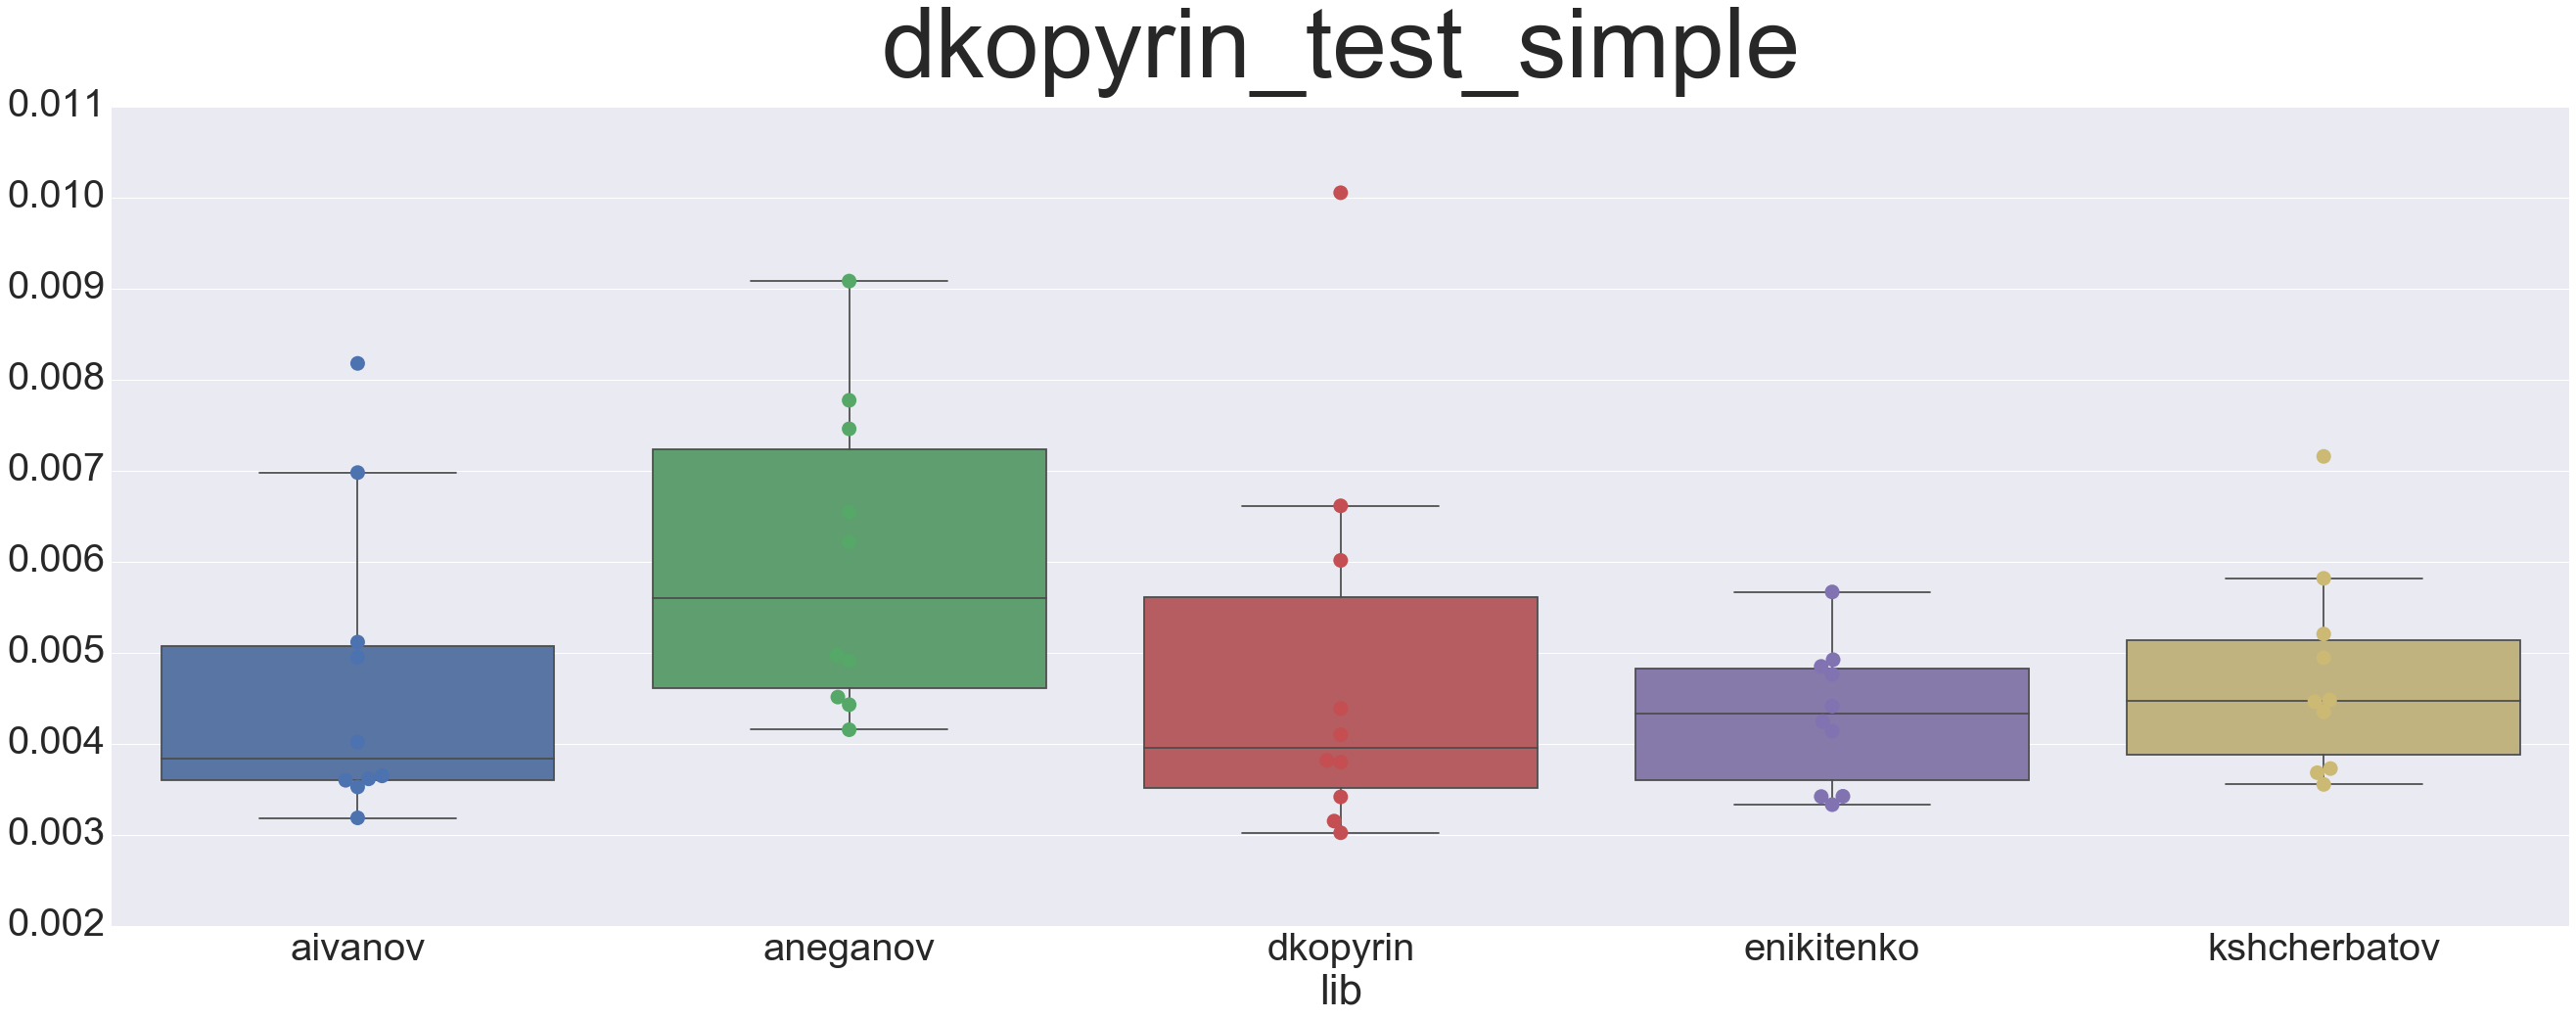

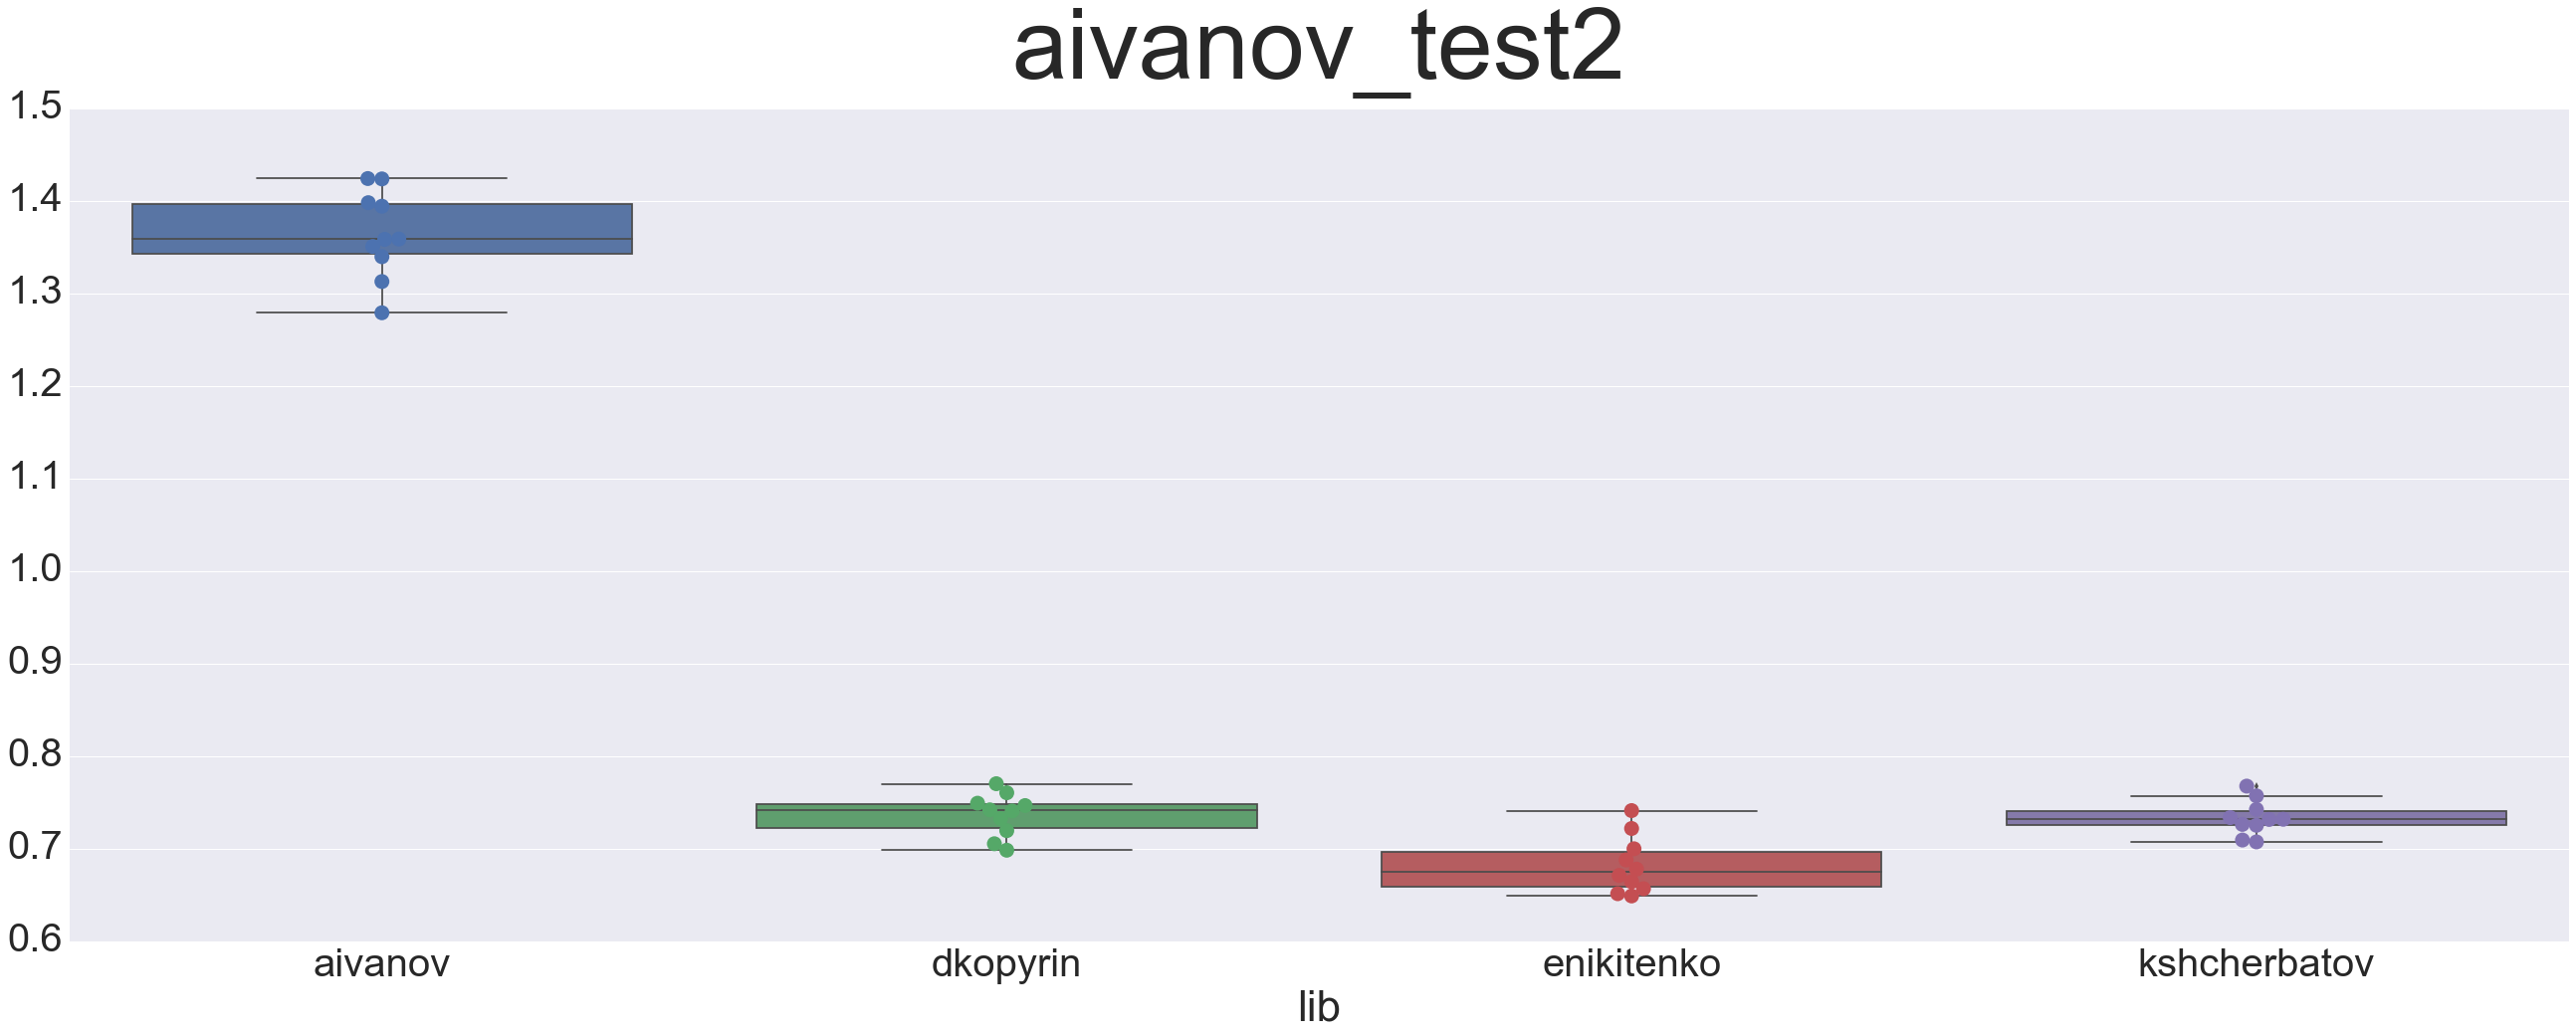

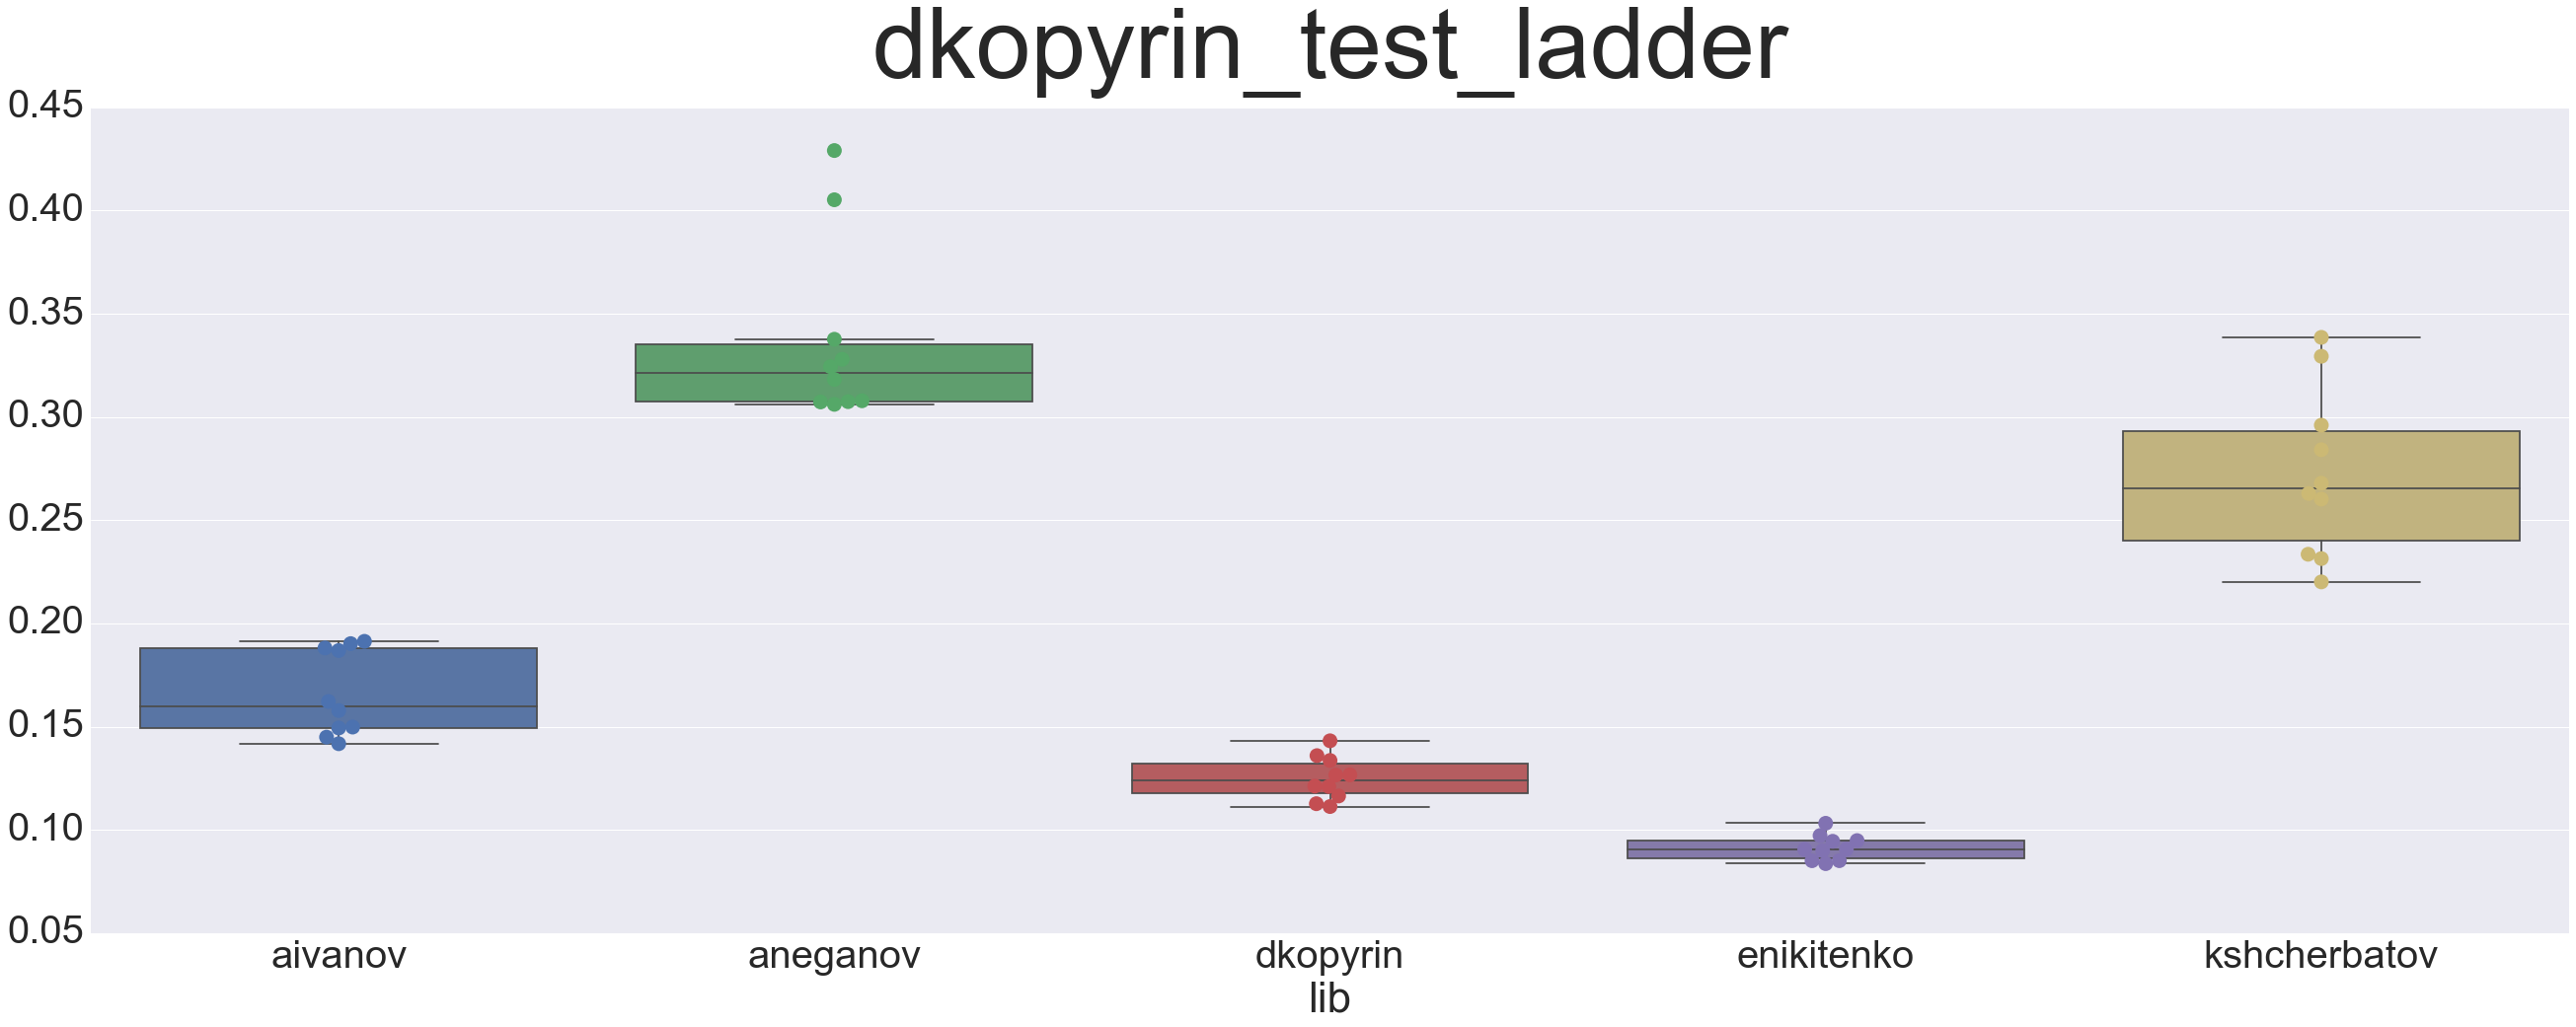

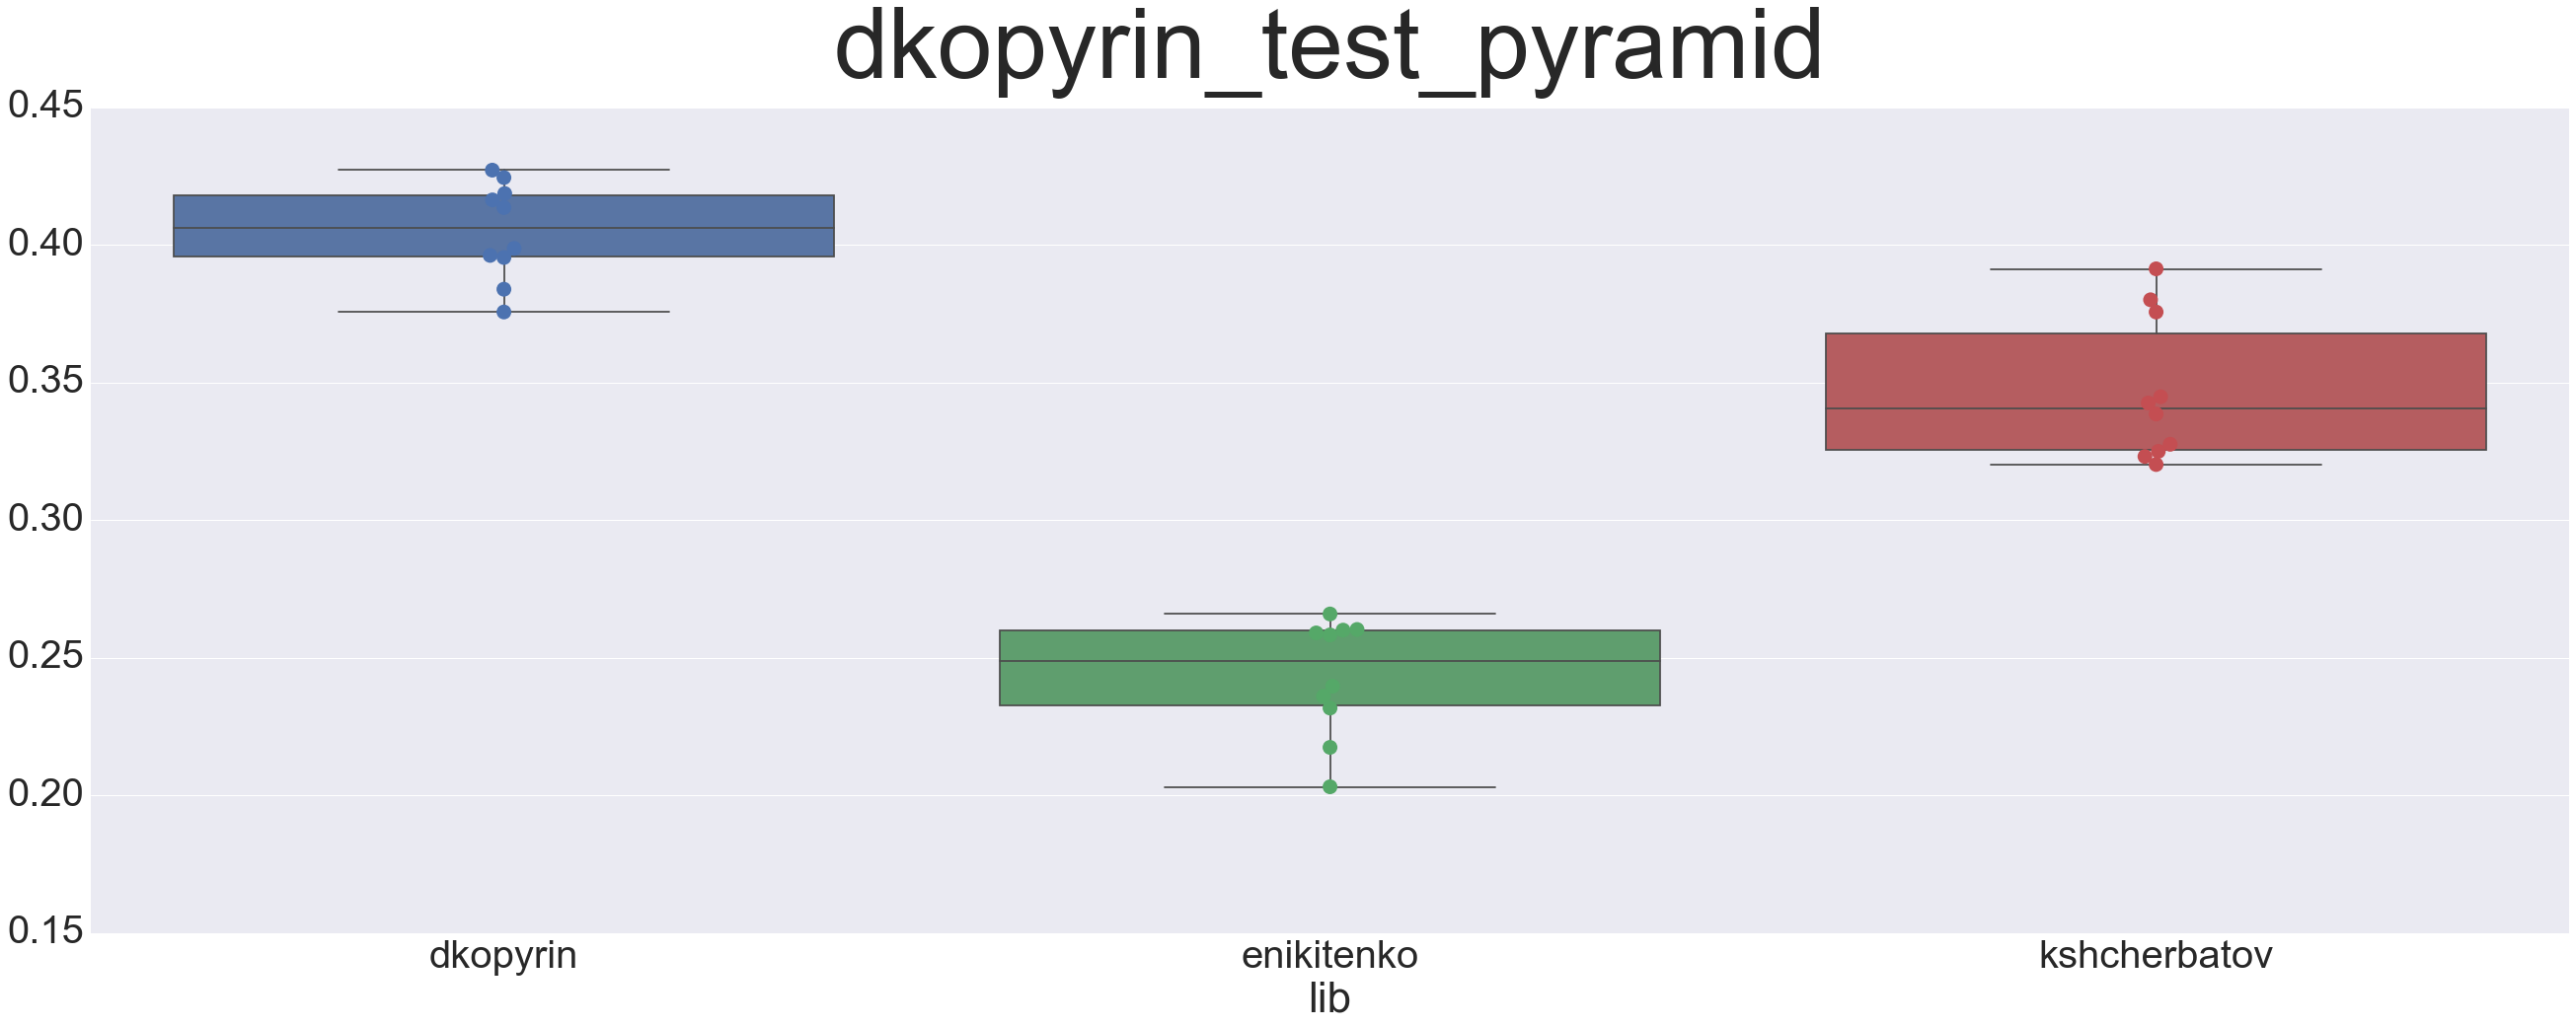

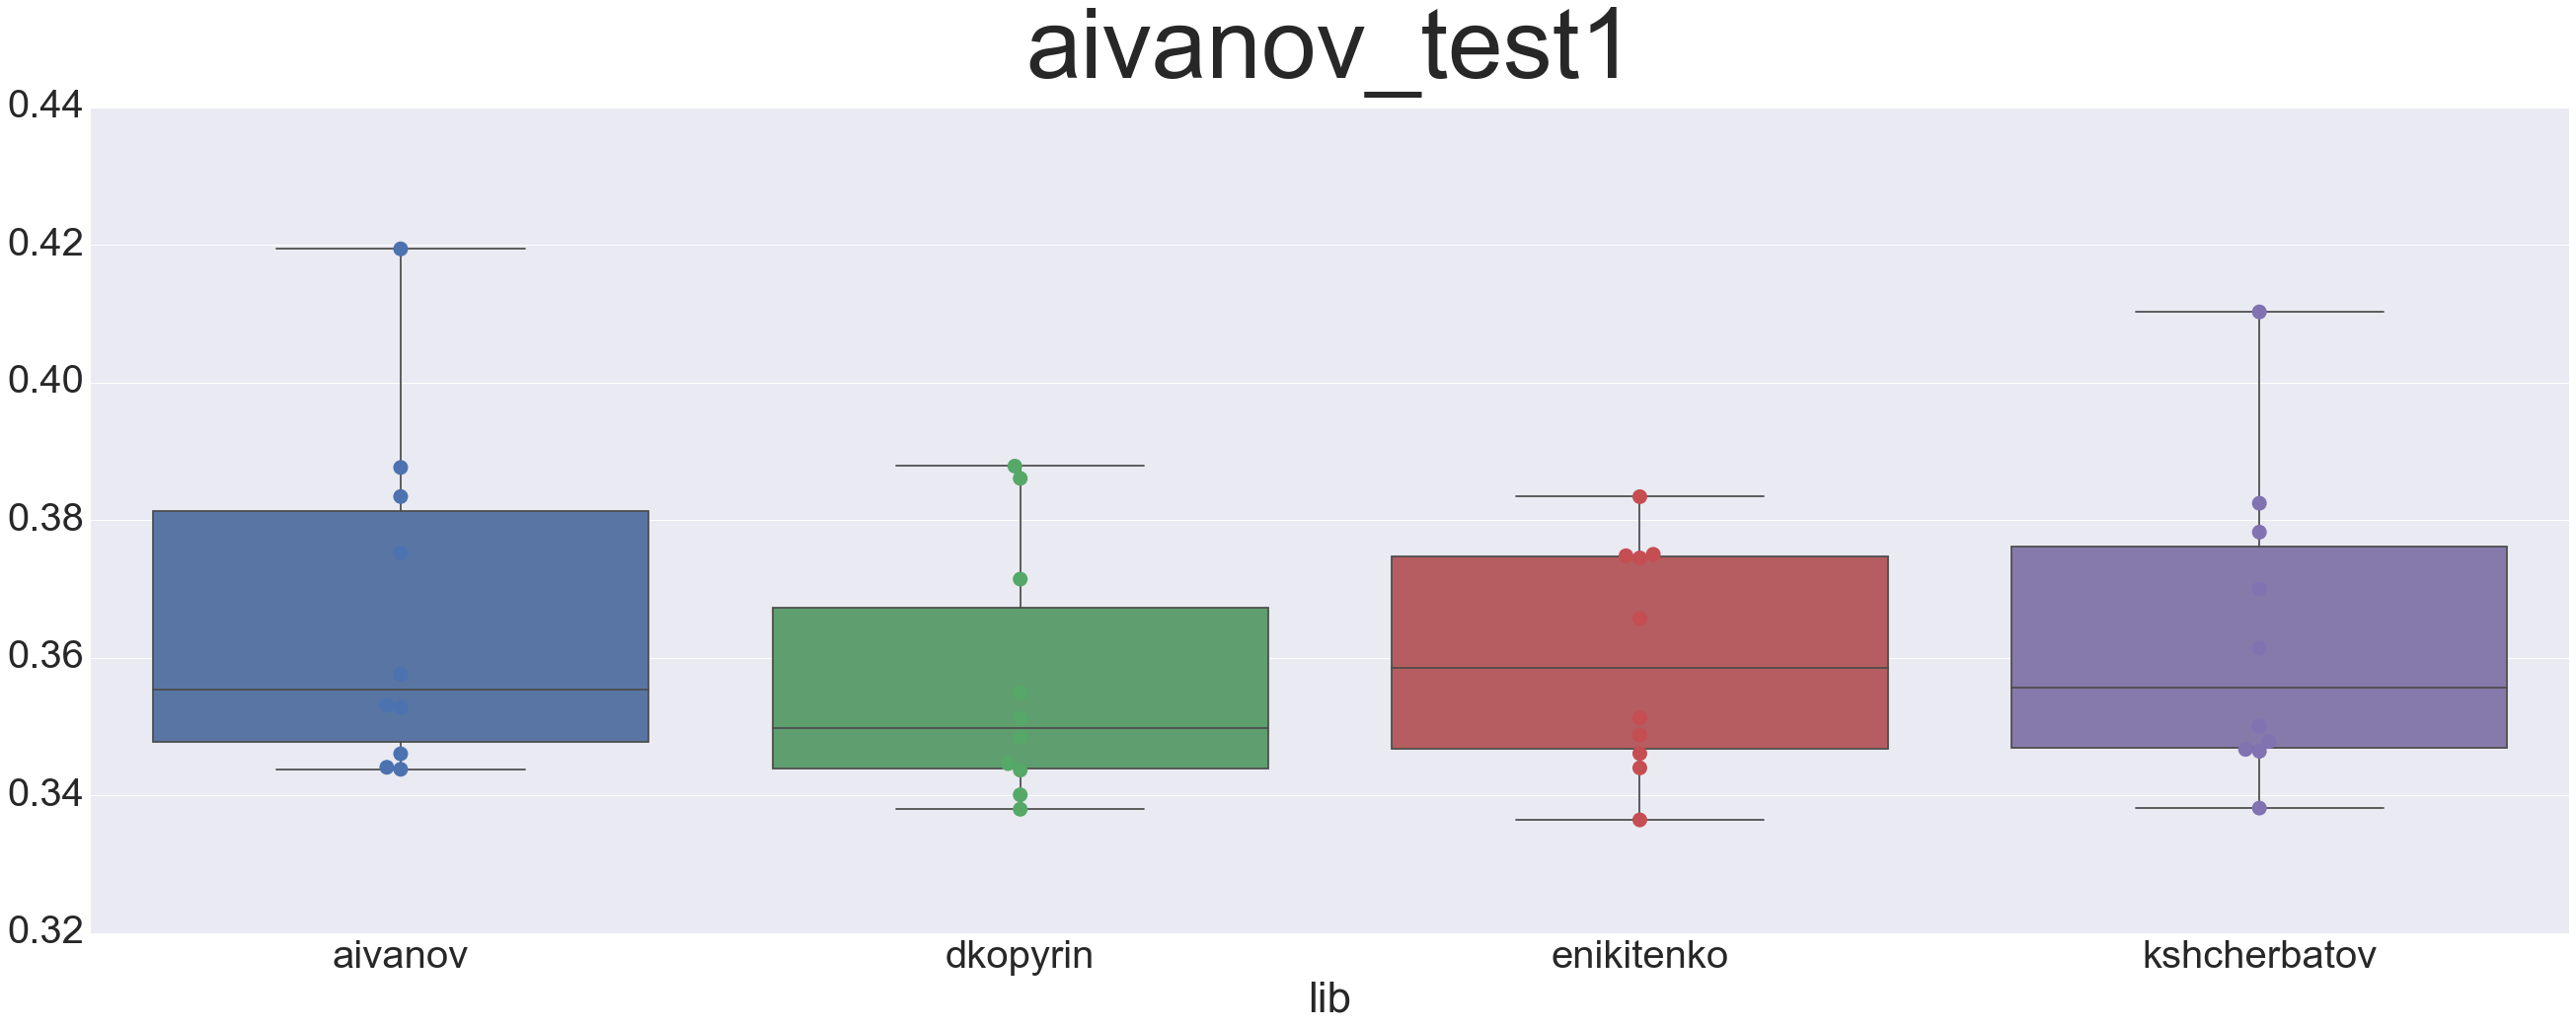

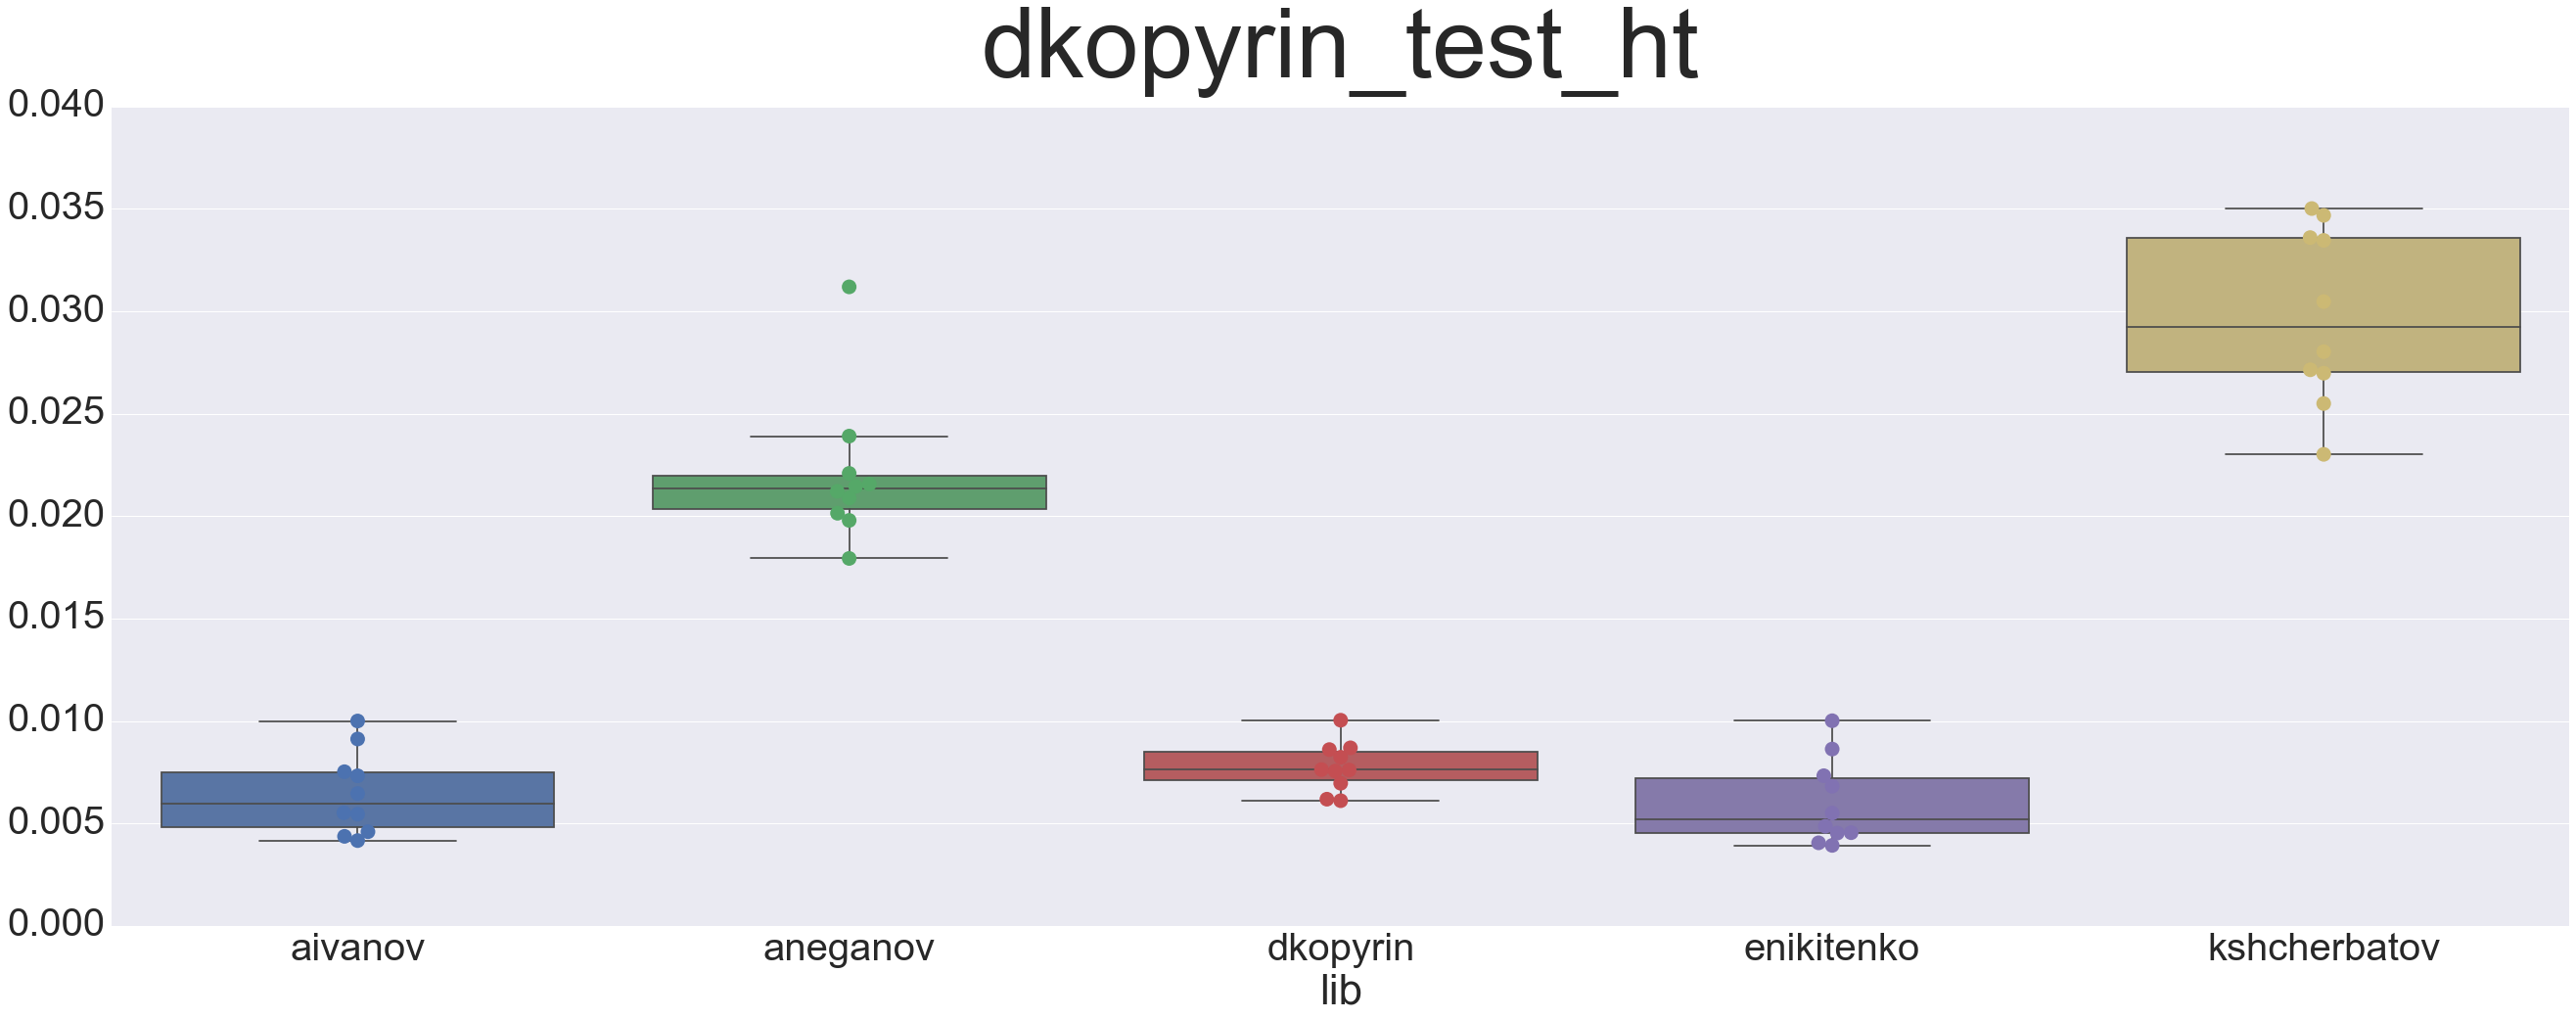

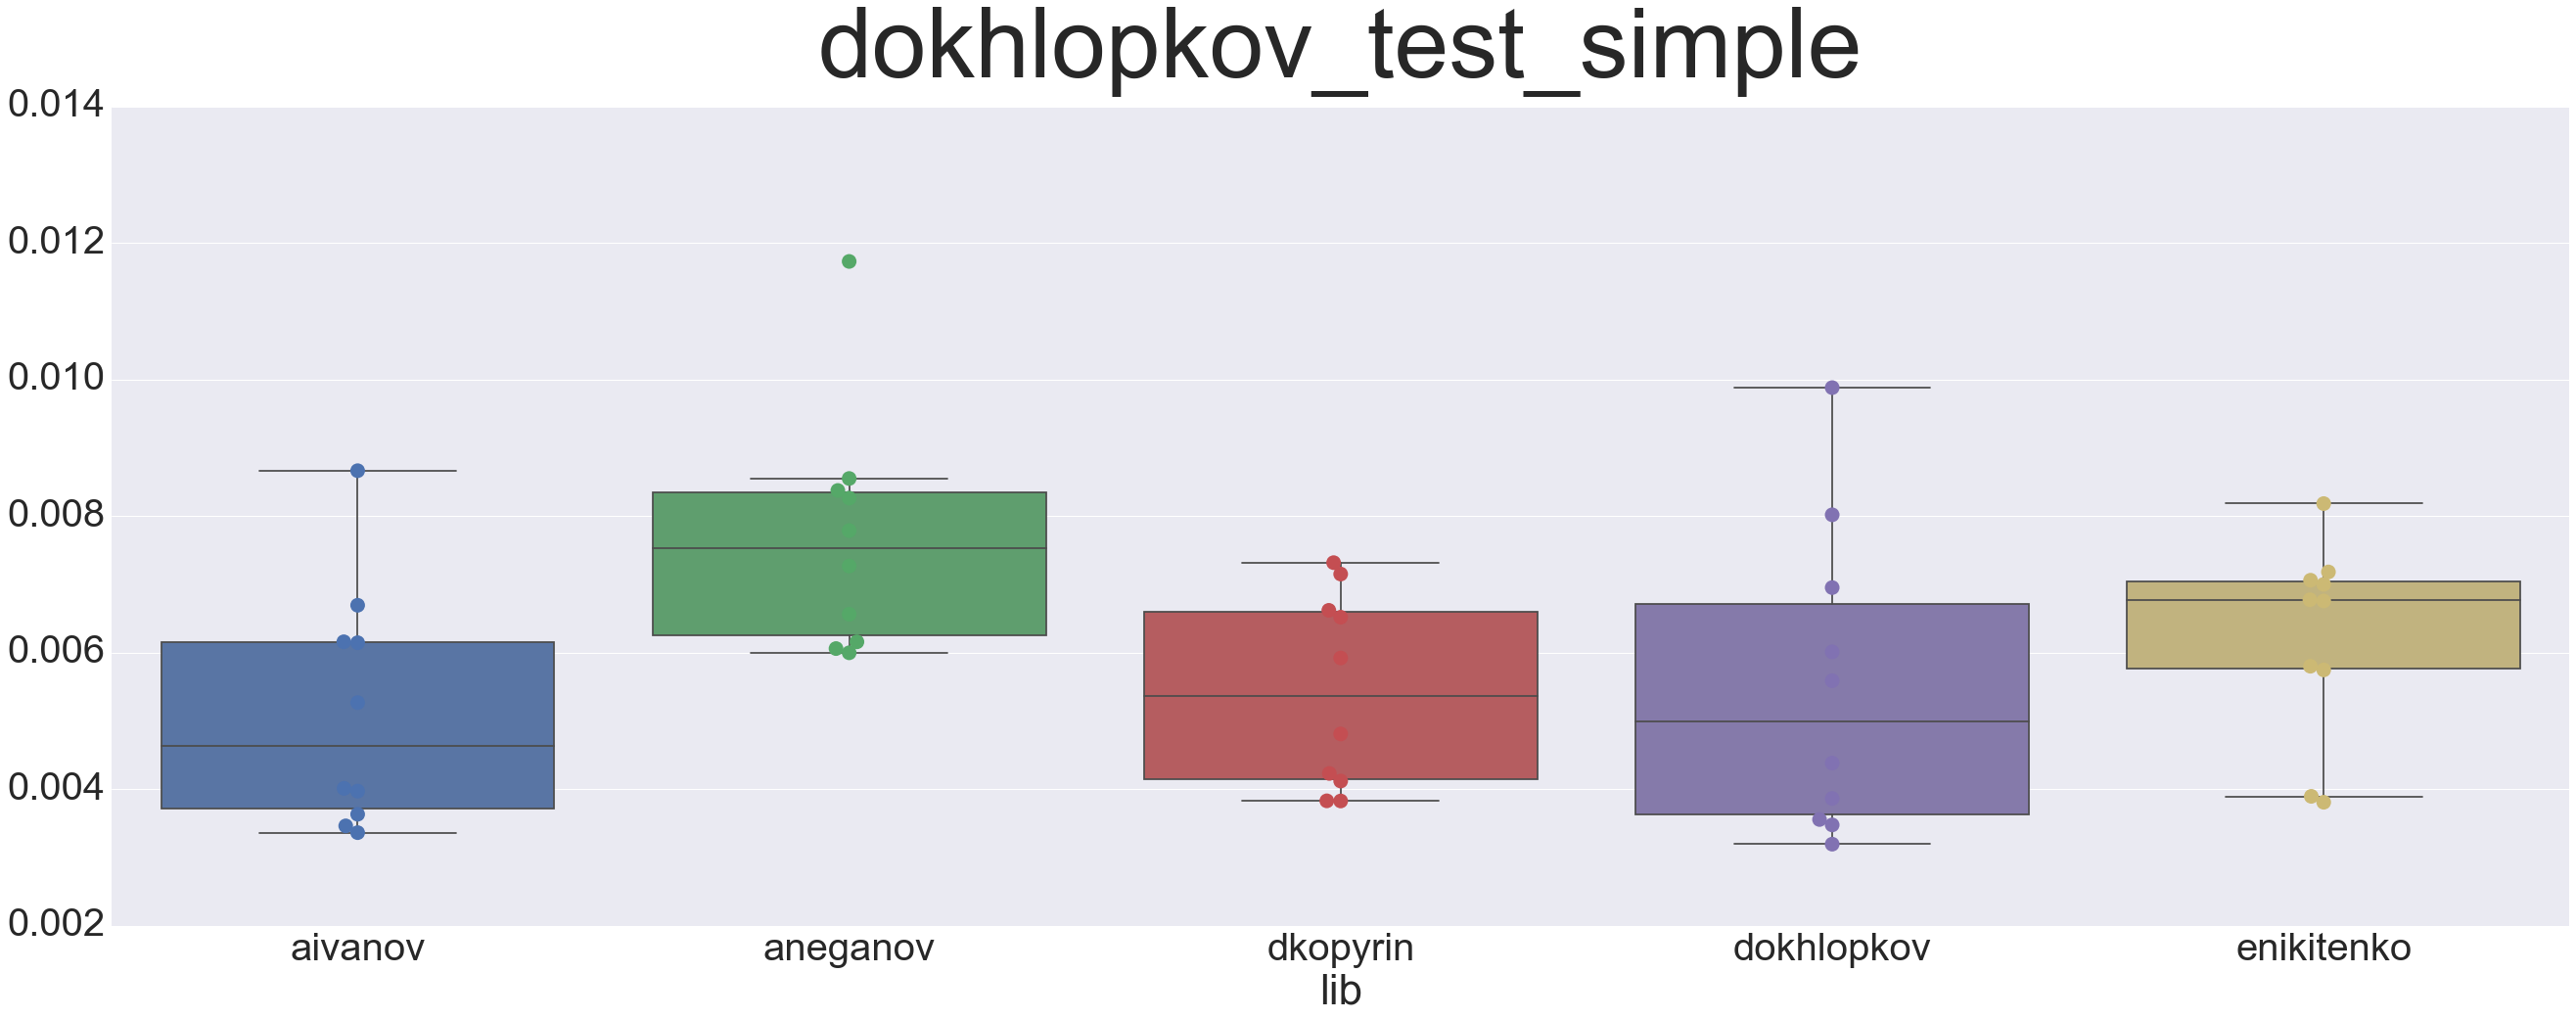

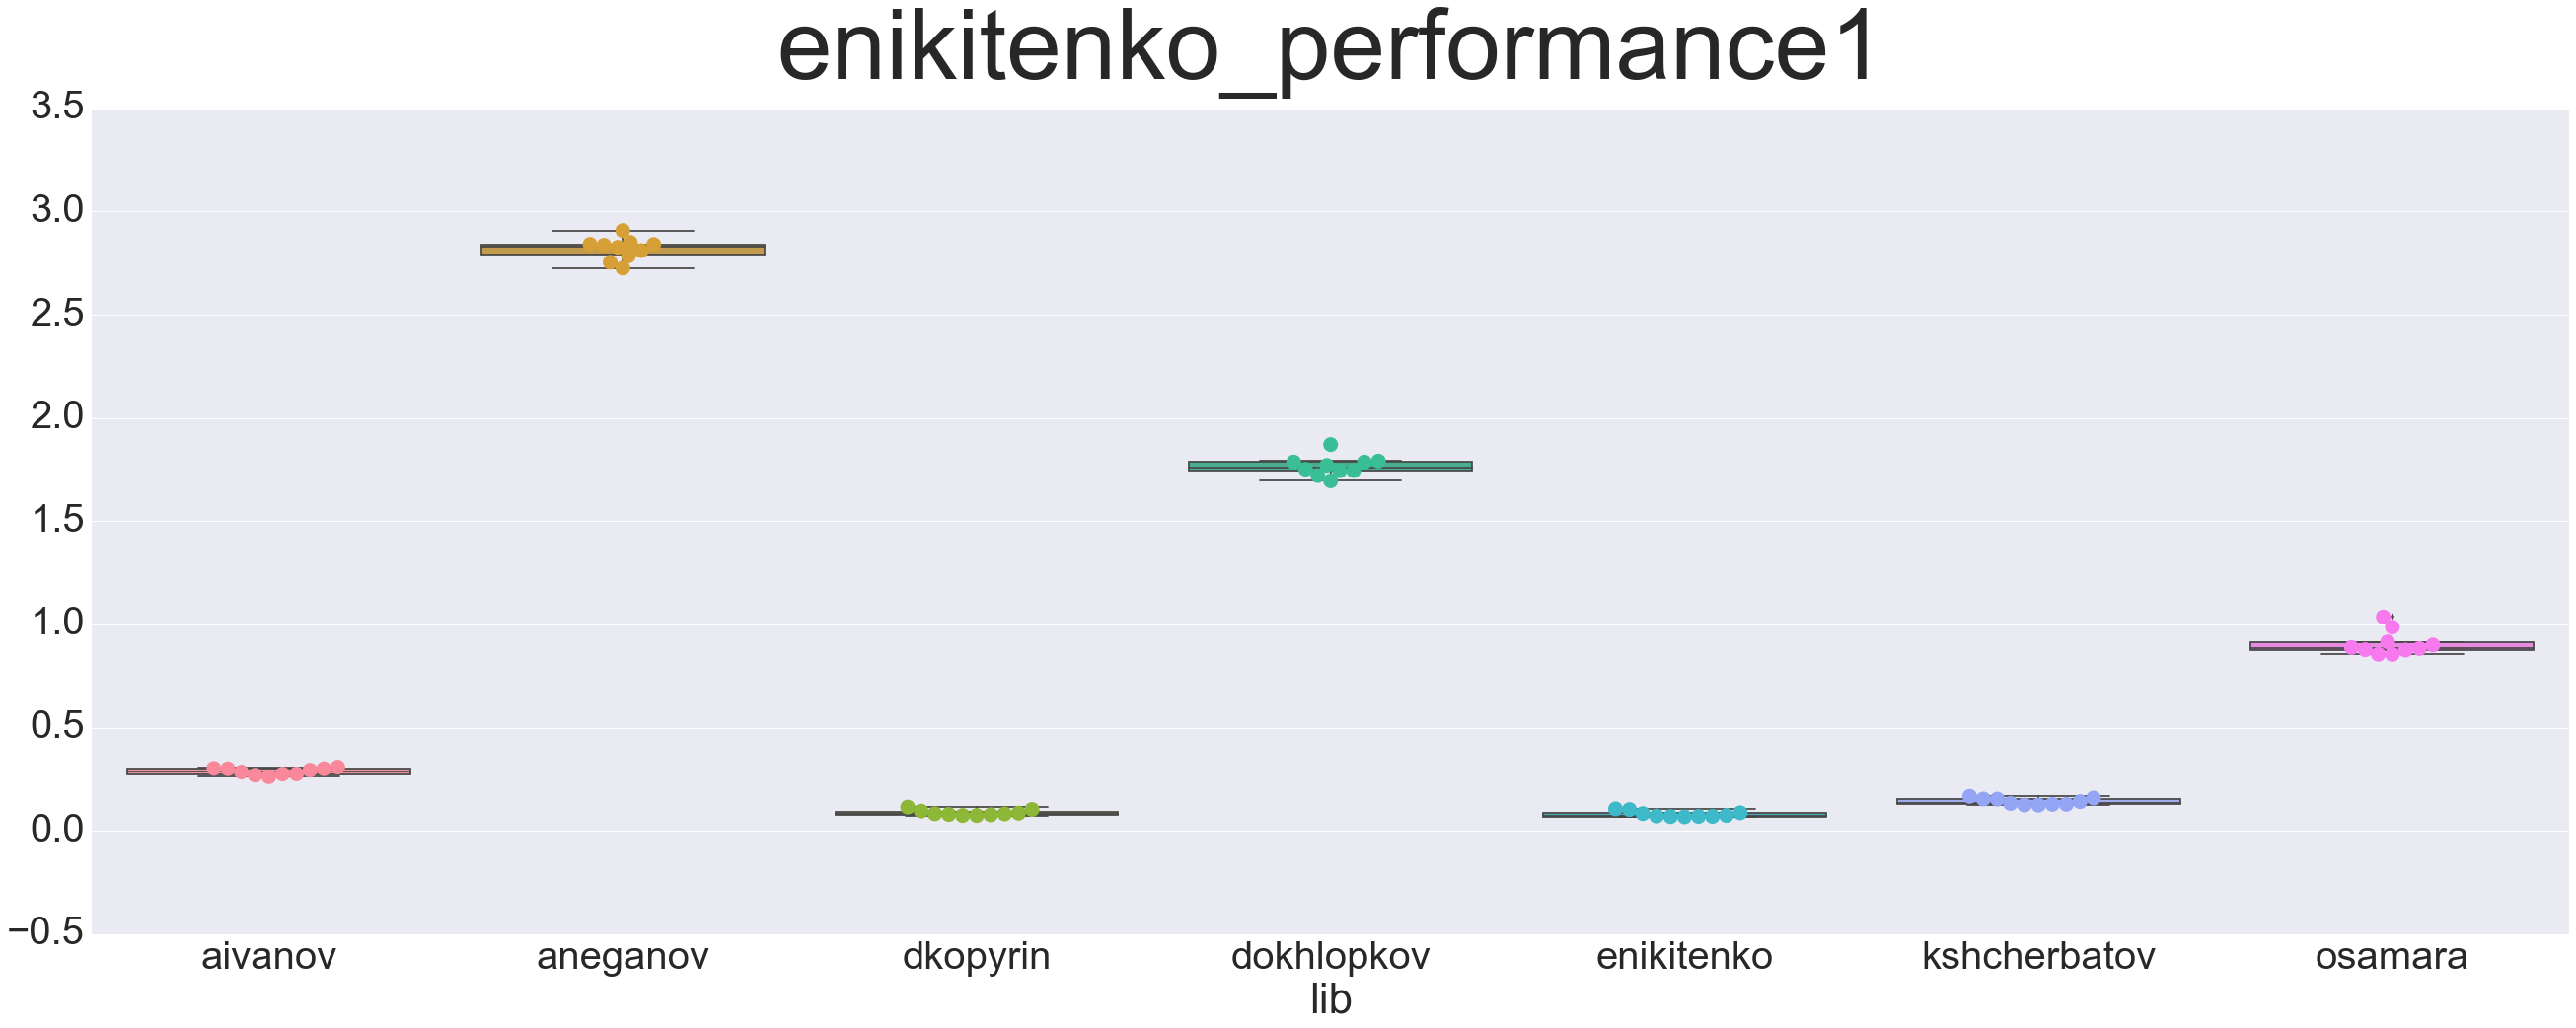

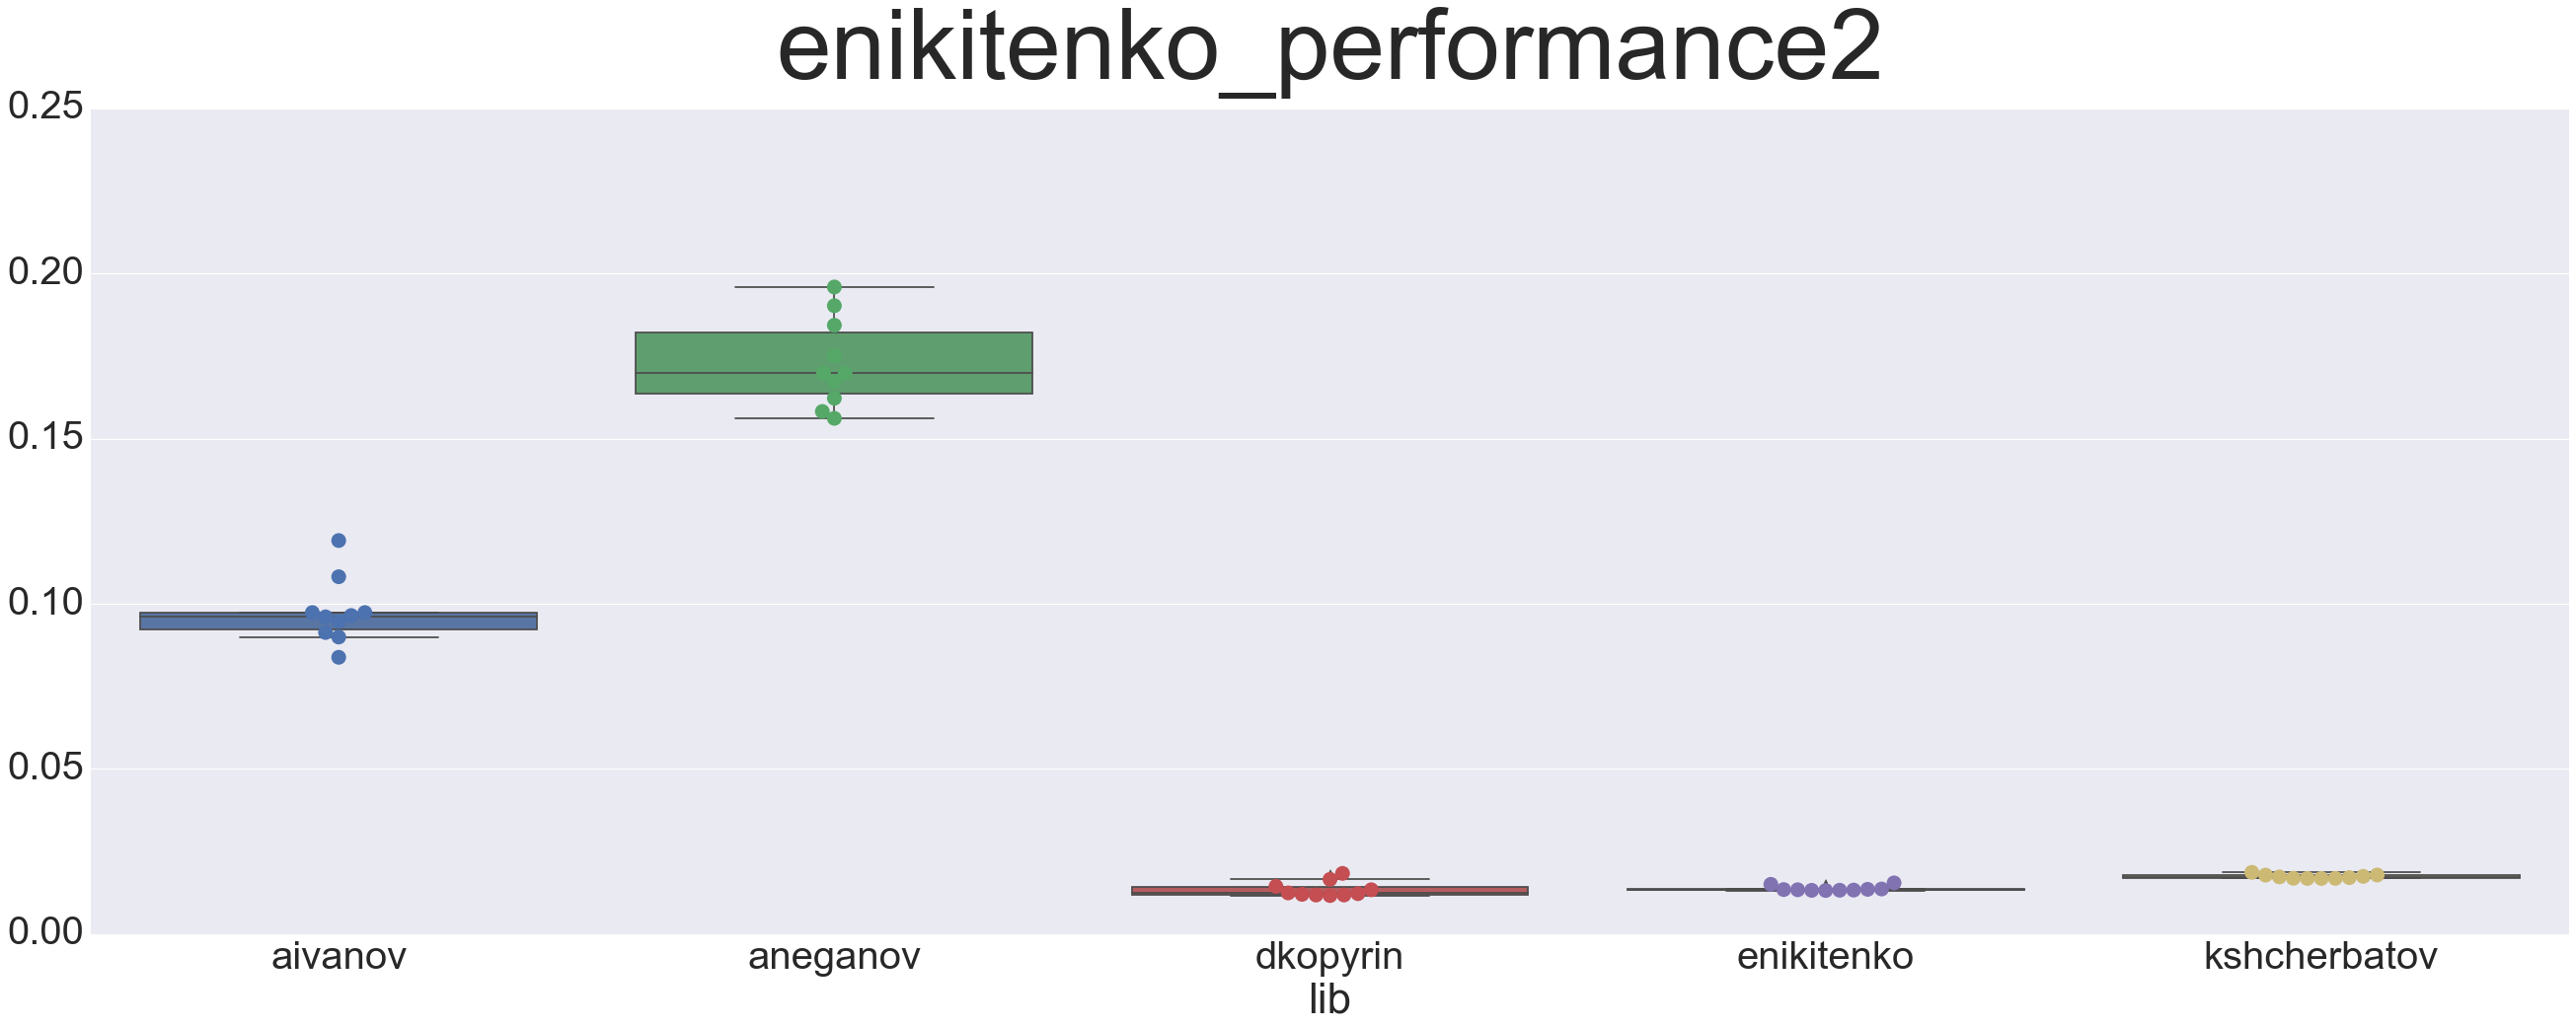

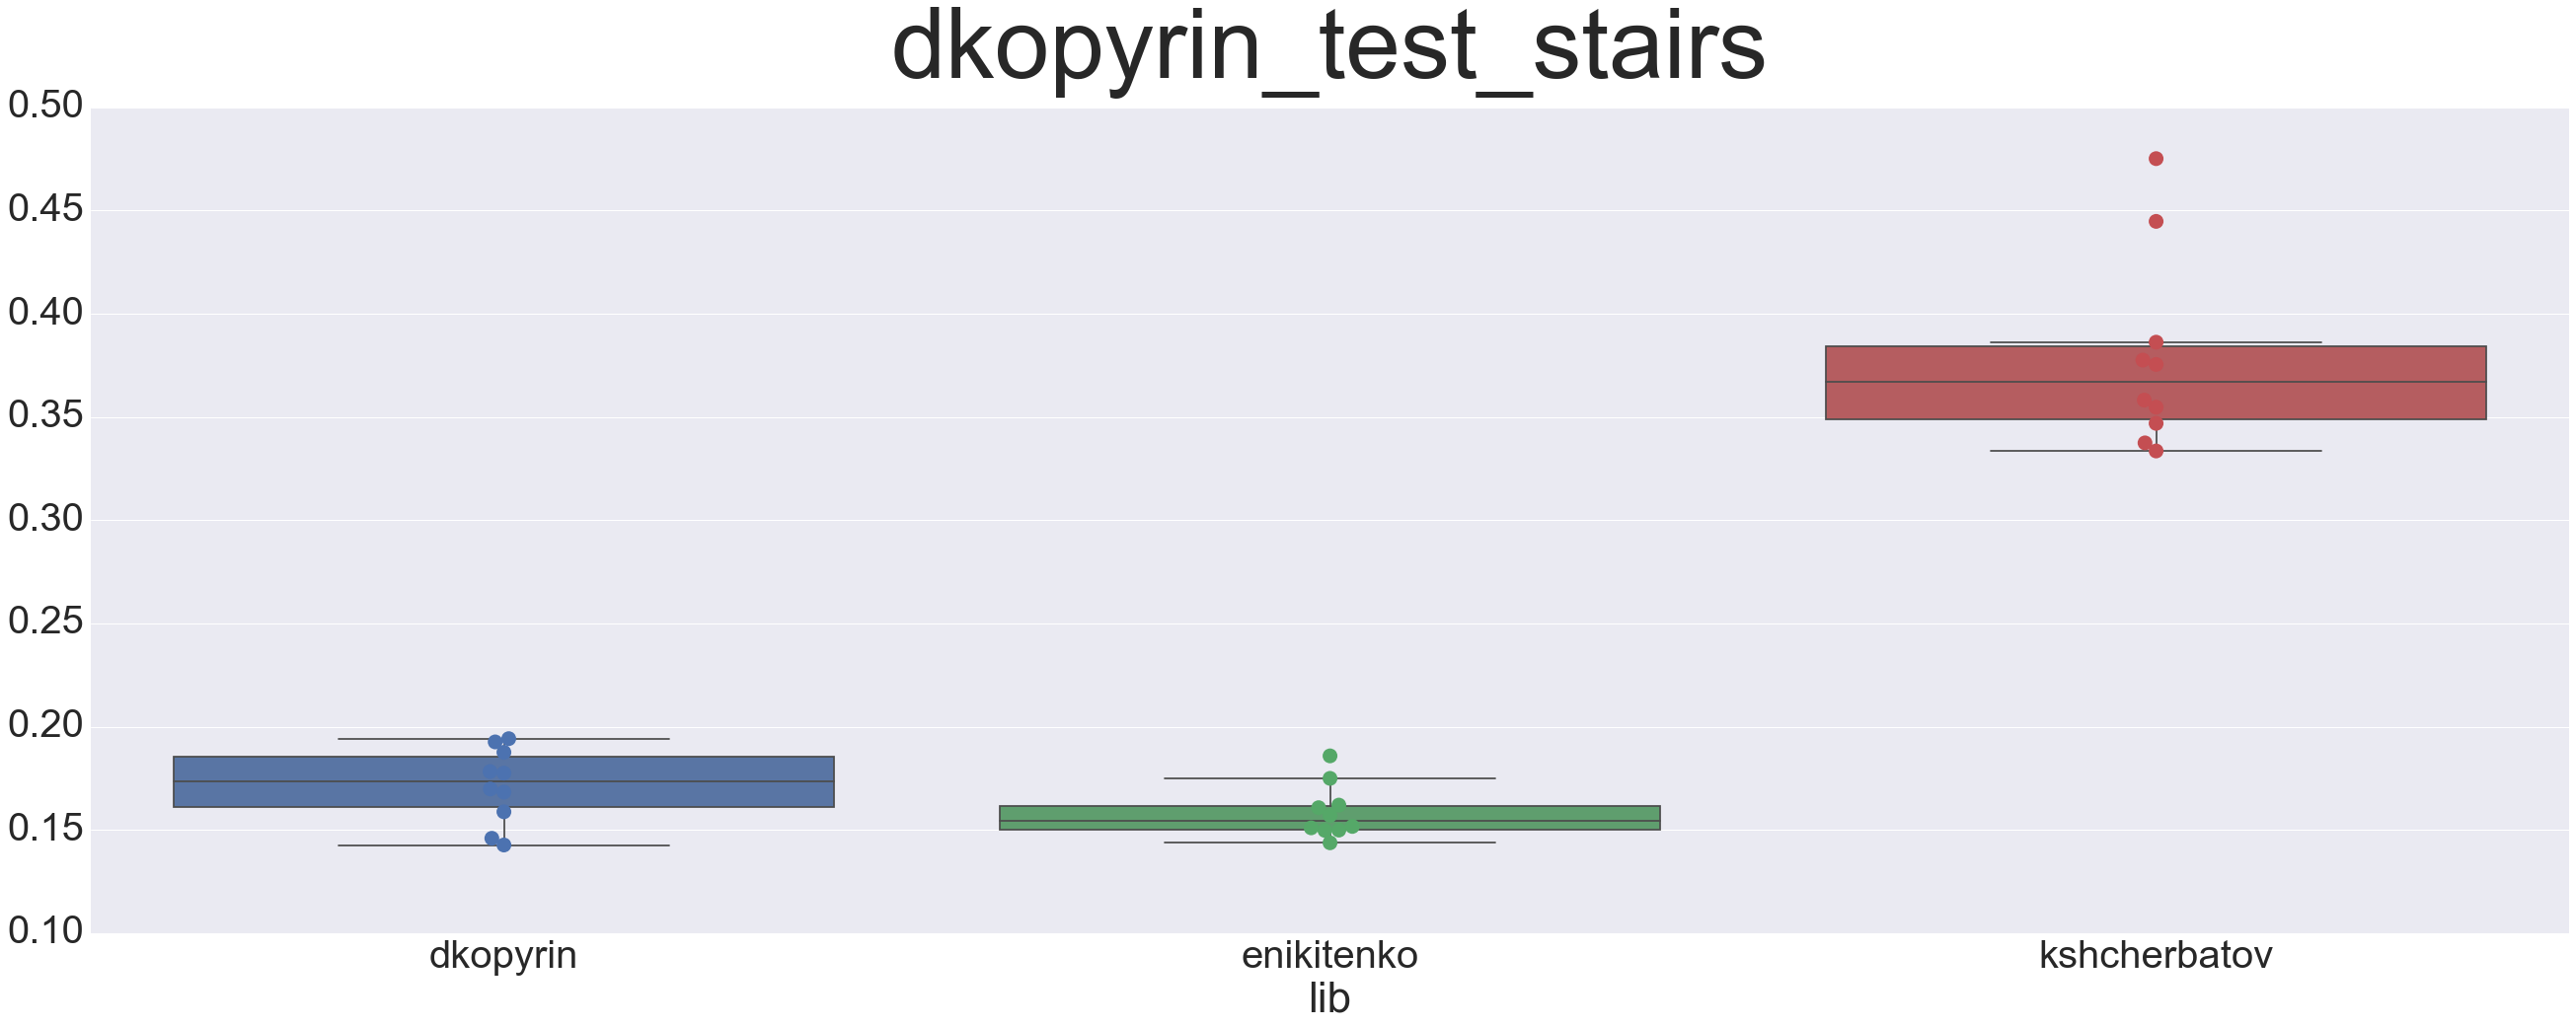

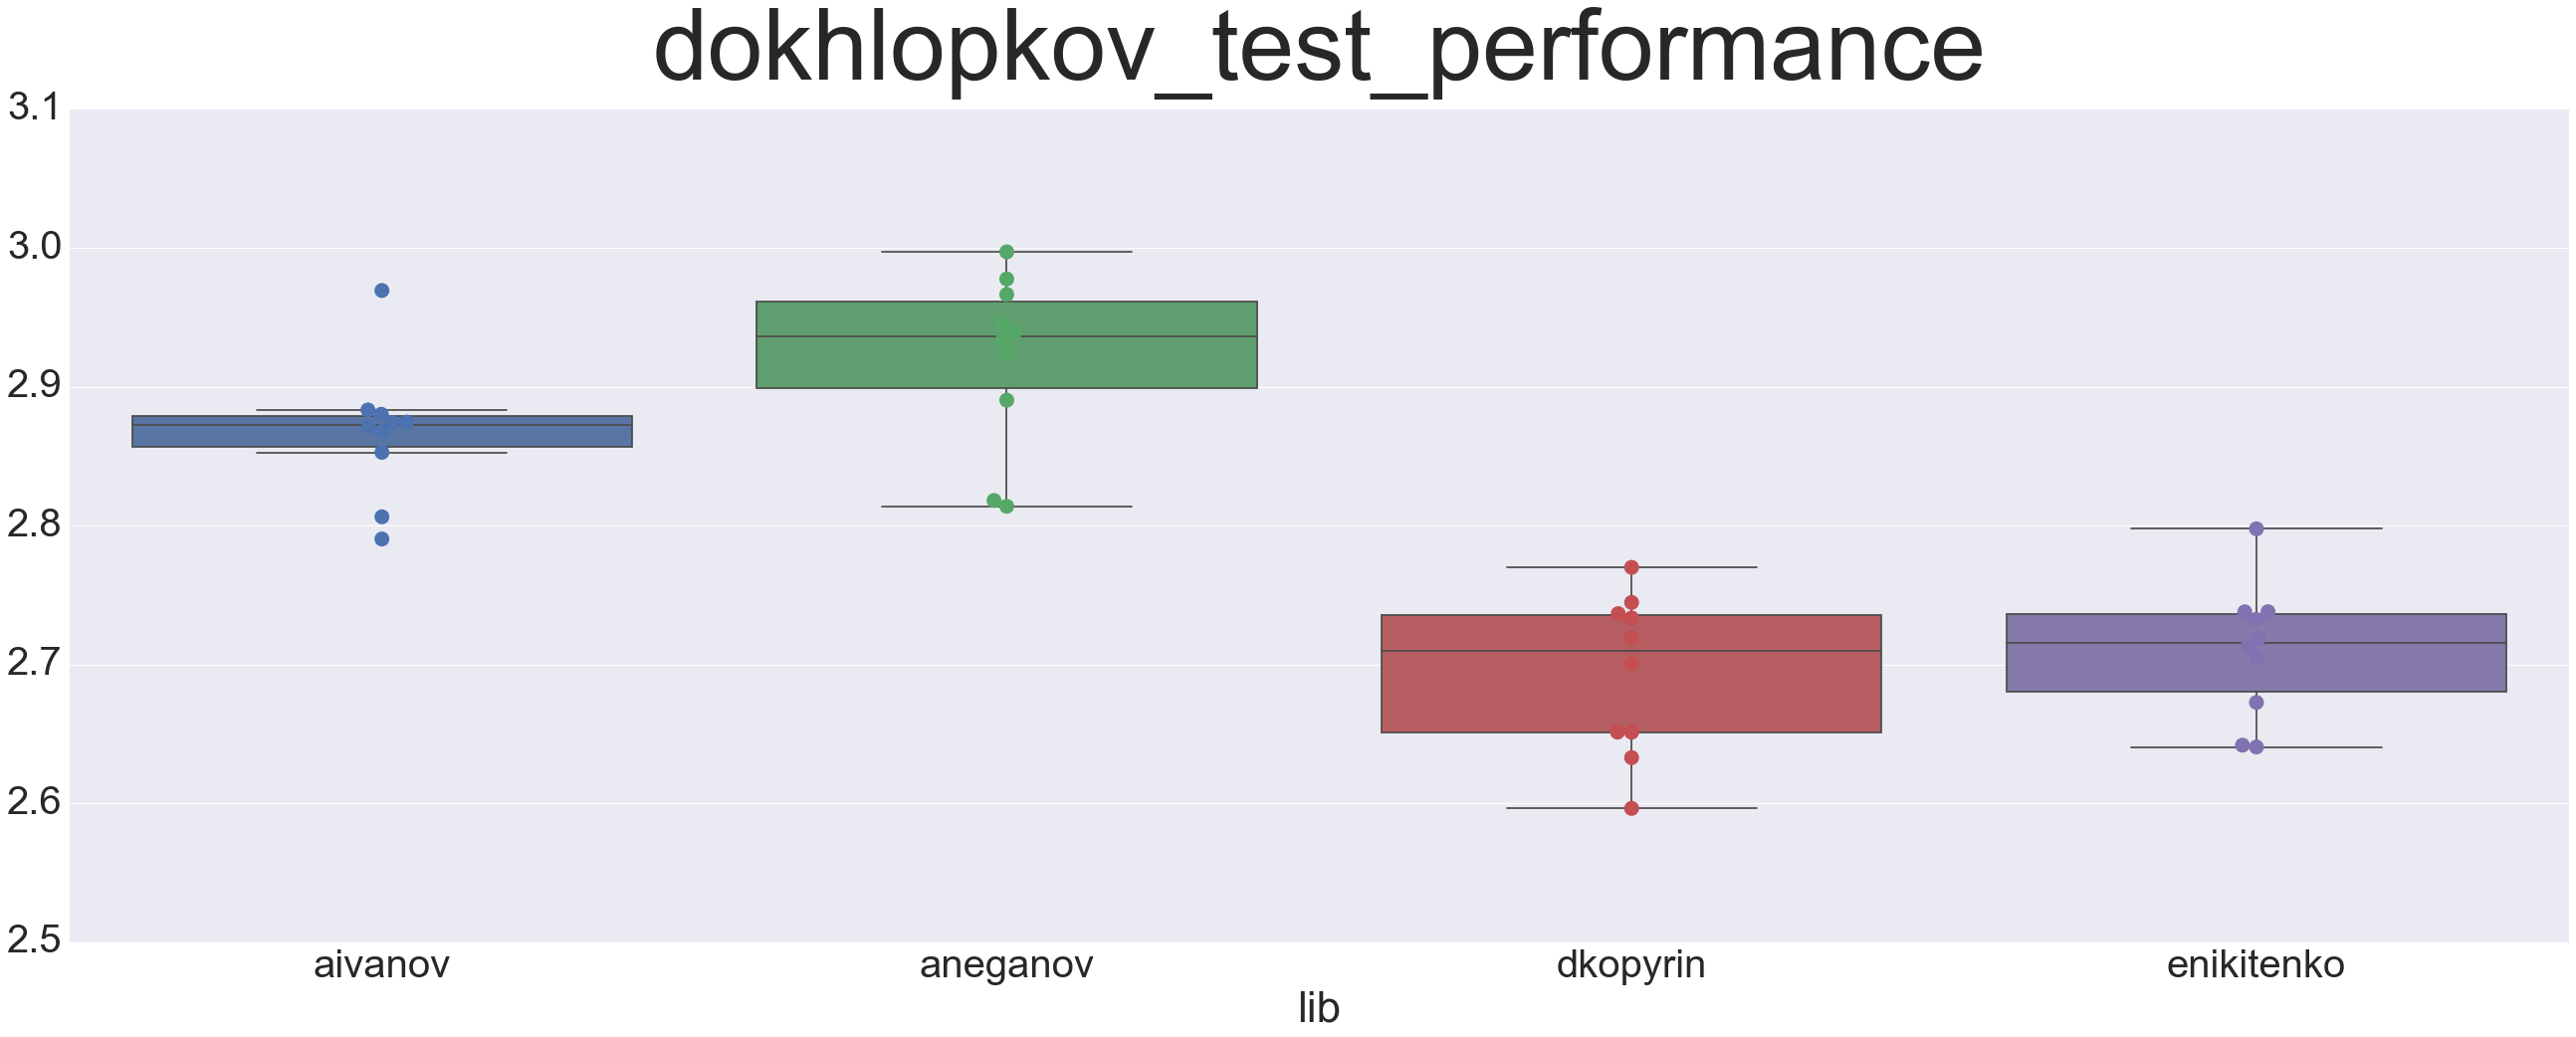

In [9]:
val = passed_data.set_index(passed_data["testid"]).drop(["test", "test_name", "mean", "std", 'testid'], axis=1)
sns.set(font_scale=4)
for test in tests:
    plt.figure(figsize=(45, 15))
    sns.plt.title(test, fontsize=100, y=1.03)
    a = val[val.index == test]
    a = a.set_index(a['lib']).drop(["lib"], axis=1).transpose()
    ax = sns.boxplot(data=a)
    sns.swarmplot(data=a, size=15, ax=ax)
    plt.show()

## Raw results 
with mean and std

In [10]:
pd.set_option('display.max_rows', len(data))
data.drop(values, axis=1)

,lib,test,test_name,mean,std,testid
0,aivanov,aivanov,test1,0.343804,NaN,aivanov_test1
1,aivanov,aivanov,test2,1.339613,NaN,aivanov_test2
2,aivanov,aneganov,test_func,0.007635,NaN,aneganov_test_func
3,aivanov,dkopyrin,test_ht,0.004593,NaN,dkopyrin_test_ht
4,aivanov,dkopyrin,test_ladder,0.191322,NaN,dkopyrin_test_ladder
5,aivanov,dkopyrin,test_pyramid,-1.000000,NaN,dkopyrin_test_pyramid
6,aivanov,dkopyrin,test_simple,0.005116,NaN,dkopyrin_test_simple
7,aivanov,dkopyrin,test_simple_map,0.004406,NaN,dkopyrin_test_simple_map
8,aivanov,dkopyrin,test_stairs,-1.000000,NaN,dkopyrin_test_stairs
9,aivanov,dokhlopkov,test_performance,2.806447,NaN,dokhlopkov_test_performance


#### Made by dokhlopkov (ohld@github, ohl.d@yandex.ru)